# 2 layer synthetic inversion

Here we try to recover the true Layer 2 topography with a gravity inversion. The gravity data is the forward gravity of Layer 1 and 2, representing a perfect gravity survey with no error. The inputs into the inversion are a full resolution Layer 1, representing the `ice surface`, and a low resolution Layer 2, representing the `bed topography`, which has been created through the random sampling and grid of 30 contraint points. In an Antarctic setting, these points represent single seismic survey locations which image the elevation of Layer 2. 

import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

from RIS_gravity_inversion import plotting, optimization, synthetic
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import os

# Load data

## topographic layers
* 2 full resolution synthetic layers
* low resolution layer 2

In [2]:
layer1 = xr.open_zarr("../synthetic_data/synthetic_layer1.zarr").z

layer2 = xr.open_zarr("../synthetic_data/synthetic_layer2.zarr").z

lowres_layer2 = xr.open_zarr("../synthetic_data/synthetic_lowres_layer2.zarr").z

# ensure all xarray are same data type
layer1 = layer1.astype(np.float64)
layer2 = layer2.astype(np.float64)
lowres_layer2 = lowres_layer2.astype(np.float64)

print(utils.get_grid_info(layer1))
print(utils.get_grid_info(layer2))
print(utils.get_grid_info(lowres_layer2))
lowres_layer2

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(1000.0, [0.0, 80000.0, 0.0, 60000.0], -550.0, 0.0, 'g')
(1000.0, [0.0, 80000.0, 0.0, 60000.0], -952.940979004, -481.448486328, 'g')
(1000.0, [0.0, 80000.0, 0.0, 60000.0], -800.682556152, -493.858032227, 'g')


<xarray.DataArray 'z' (northing: 61, easting: 81)>
dask.array<astype, shape=(61, 81), dtype=float64, chunksize=(61, 81), chunktype=numpy.ndarray>
Coordinates:
  * easting   (easting) float64 0.0 1e+03 2e+03 3e+03 ... 7.8e+04 7.9e+04 8e+04
  * northing  (northing) float64 0.0 1e+03 2e+03 3e+03 ... 5.8e+04 5.9e+04 6e+04
Attributes:
    actual_range:  [-800.6825561523438, -493.8580322265625]
    long_name:     z

## gravity data
* full resolution gravity grid
* gravity observations

In [3]:
# full resolution gravity point data
full_res_grav = pd.read_csv(
    "../synthetic_data/synthetic_2layer_full_res_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# sampled gravity point data
sampled_grav = pd.read_csv(
    "../synthetic_data/synthetic_2layer_sampled_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# Set region and parameters

Use the same regions and parameters as `synthetic_model_2layer.ipynb`

In [4]:
layer_spacing, inversion_region, _, _, registration = utils.get_grid_info(layer2)

# set gravity observation parameters
grav_observation_height = 1e3
sampled_grav_spacing = 2e3

buffer_region = utils.alter_region(
    inversion_region,
    buffer=0,
)[1]

print(f"spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

spacing: 1000.0m
registration: g
inversion region =  [0.0, 80000.0, 0.0, 60000.0]
buffer region =  [0, 80000, 0, 60000]


### prep grav data

In [5]:
full_res_grav = inv_utils.prep_grav_data(
    full_res_grav,
    region=inversion_region,
    input_grav_name="forward_total",
    input_coord_names=("easting", "northing", "upward"),
)

sampled_grav = inv_utils.prep_grav_data(
    sampled_grav,
    region=inversion_region,
    input_grav_name="Gobs",
    input_coord_names=("easting", "northing", "upward"),
)

print(f"full resolution gravity: {len(full_res_grav)} points")
print(f"sampled gravity: {len(sampled_grav)} points")

print(f"gravity avg. elevation: {int(np.nanmean(full_res_grav.upward))}")

full resolution gravity: 4941 points
sampled gravity: 1271 points
gravity avg. elevation: 1000


## constraint points

In [6]:
# load constraint points into a dataframe
constraint_points_all = pd.read_csv(
    "../synthetic_data/synthetic_constraints.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within inversion region
constraint_points = utils.points_inside_region(
    constraint_points_all, inversion_region, names=("easting", "northing")
)

print(f"bathymetry control points:{len(constraint_points)}")
constraint_points.head()

bathymetry control points:30


,easting,northing,upward
0,33361.760376,5900.810030,-718.817246
1,57625.959475,25266.457500,-750.543650
2,9.149985,57473.371809,-492.362531
3,24186.605811,31989.917098,-688.832116
4,11740.471265,41512.626837,-604.955236


## plot inputs

returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


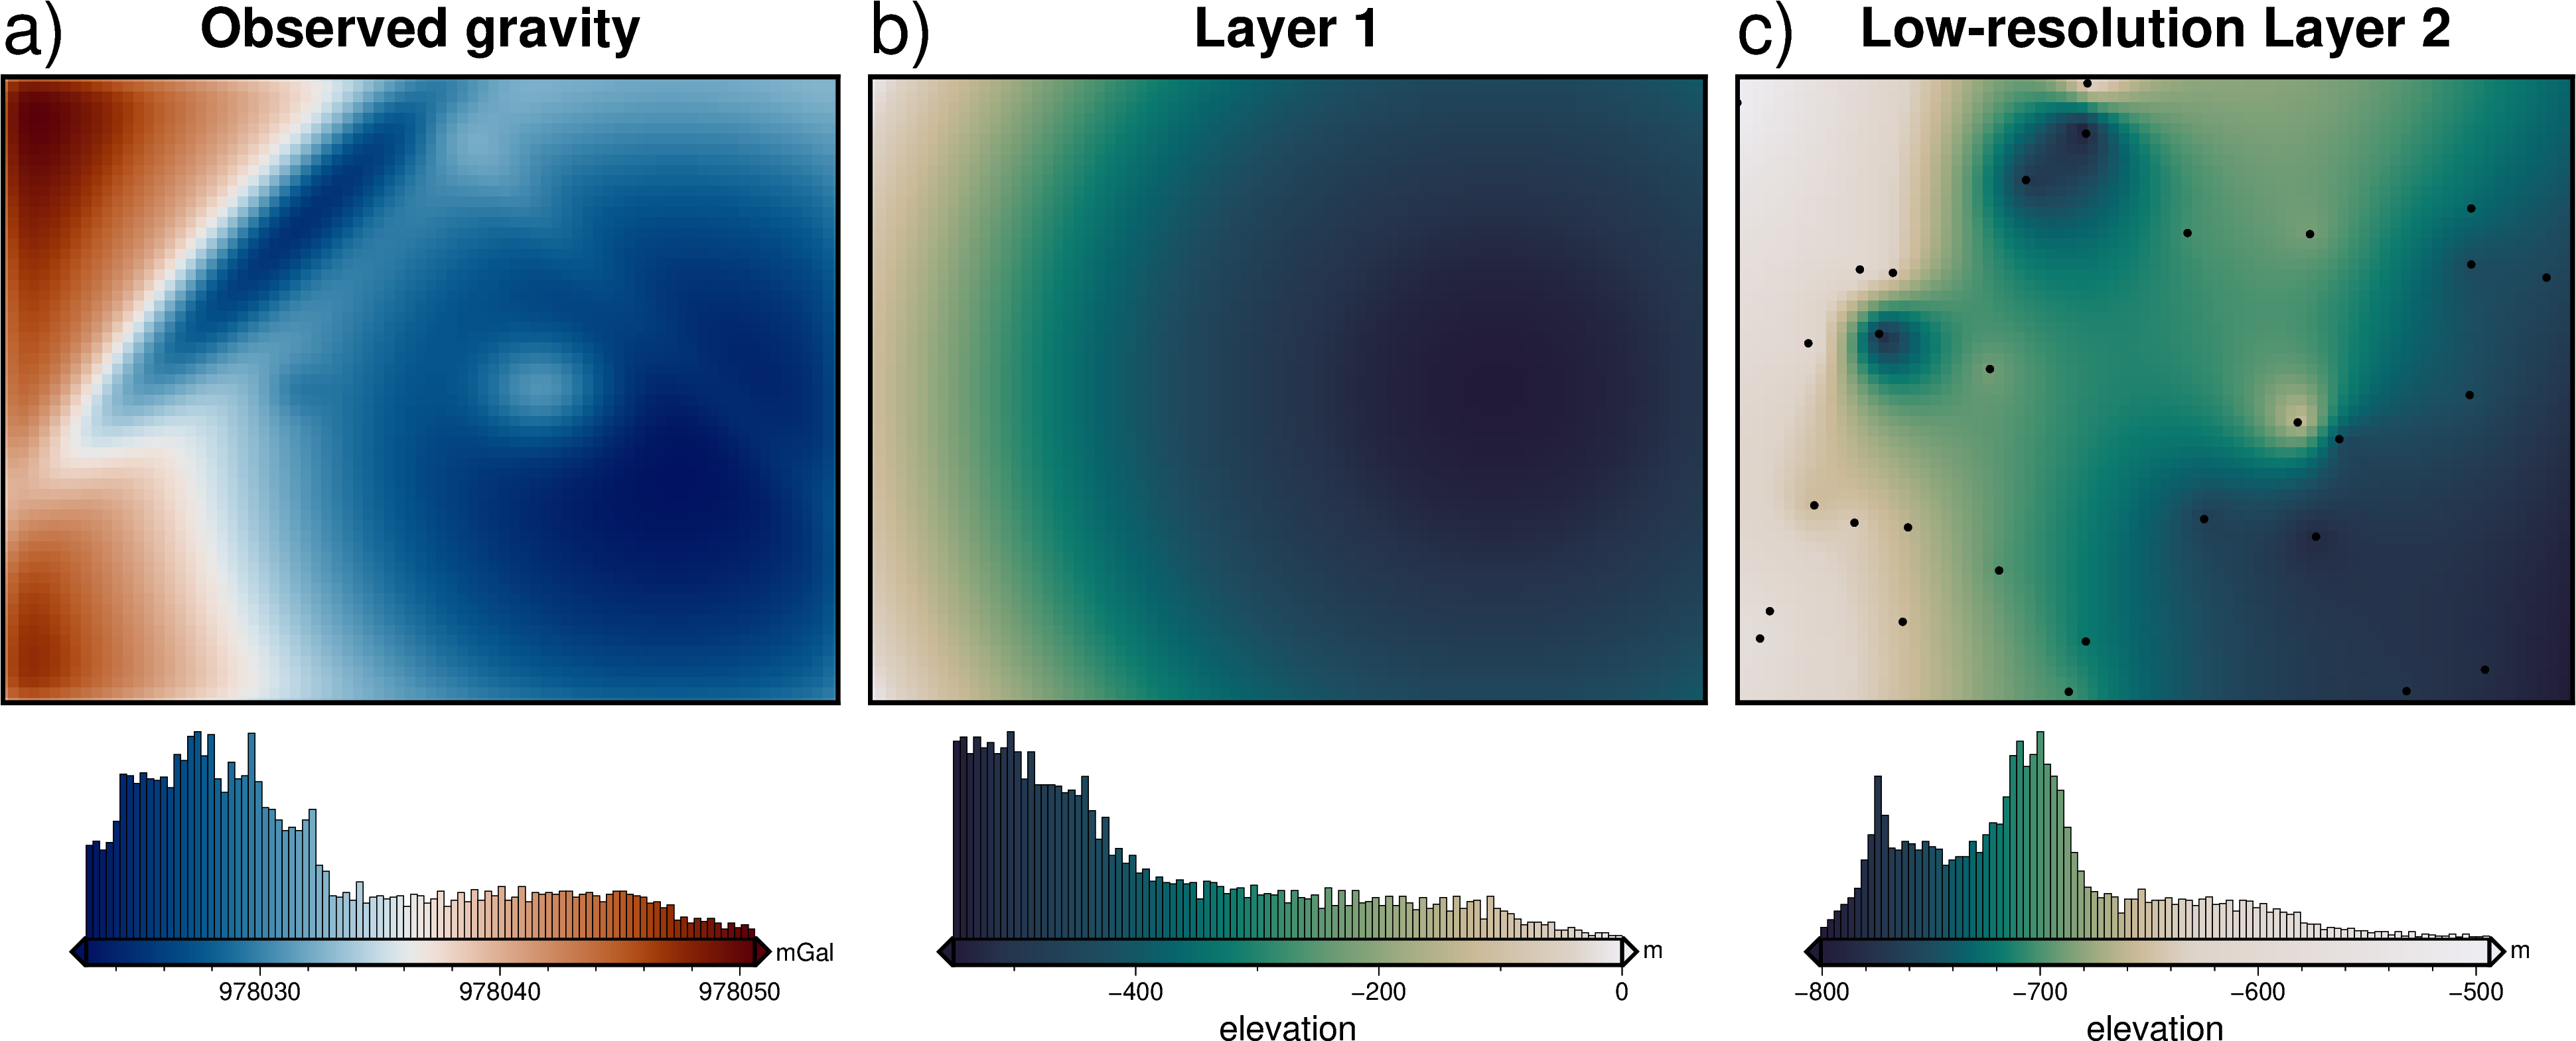

In [8]:
# grid the observed gravity
Gobs = full_res_grav.set_index(["northing", "easting"]).to_xarray().Gobs

# plot observed gravity
fig = maps.plot_grd(
    grid=Gobs,
    fig_height=8,
    cmap="vik",
    region=buffer_region,
    title="Observed gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

# plot layer 1
fig = maps.plot_grd(
    grid=layer1,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Layer 1",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=lowres_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Low-resolution Layer 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)
fig.text(
    position="TL",
    justify="BL",
    text="c)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

fig.show()

# Full resolution observed gravity

# Bouguer correction

The `observed gravity` includes a gravitational signal from density contrast across Layer 1 (air-ice) and Layer 2 (ice-bed). Since we want to invert for Layer 2, we need to remove the component of this gravity from Layer 1. To do this, we build a series of vertical prisms around a flat reference, which we take to be the mean value of Layer 1. The prisms extend above or below this reference, towards Layer 1. Prisms above the reference are assigned a positive density contrast ($\rho_{ice}$ - $\rho_{air}$), while prisms below the reference are assigned a negative density contrast ($\rho_{air}$ - $\rho_{ice}$). This is shown in b) and c) of the below figure.

At each stage of the inversion, the we ensure the updated bed elevation doesn't intersect Layer 1. This means the Layer 1 density contrast will be constant throughout the inversion, and can thus be calculated and accounted for only once, at the beginning. 

Here, we calculate the forward gravity of this density contrast, and remove it from the observed gravity to make a `corrected observed gravity`. 

<img src="../figures/synthetic_model_simple_2layer.svg" width="1000"/>

## Ice prisms

In [7]:
# create prisms around Layer 1
# positive densities above reference, negative below
layer1_prisms = inv_utils.grids_to_prisms(
    surface=layer1,
    reference=layer1.values.mean(),
    density=xr.where(layer1 >= layer1.values.mean(), 917, -917),
)

# plotting.show_prism_layers(
#     [layer1_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

## Ice gravity

In [25]:
# calculate gravity of layer1
layer1_grav_grid, layer1_grav_df = inv_utils.forward_grav_of_prismlayer(
    [layer1_prisms],
    full_res_grav,
    names=["layer1_prisms"],
    remove_median=False,
    progressbar=True,
    plot=False,
)

full_res_grav["layer1_forward"] = layer1_grav_df.forward_total

# subtract from observed gravity
full_res_grav["Gobs_corr"] = full_res_grav.Gobs - full_res_grav.layer1_forward

# center on 0
# full_res_grav['Gobs_corr'] -= full_res_grav['Gobs_corr'].median()

# grid the results
layer1_forward = (
    full_res_grav.set_index(["northing", "easting"]).to_xarray().layer1_forward
)
Gobs_corr = full_res_grav.set_index(["northing", "easting"]).to_xarray().Gobs_corr

# center on 0
# layer1_forward -= np.median(layer1_forward)
# Gobs_corr -= np.median(Gobs_corr)
full_res_grav

  0%|                                                  | 0/4941 [00:00<?, ?it/s]

,northing,easting,Layer1,Layer2,Gobs,upward,layer1_forward,Gobs_corr
0,0.0,0.0,5.504590,2.609273,978040.113863,1000.0,5.504590,978034.609273
1,0.0,1000.0,6.836422,3.247036,978042.083458,1000.0,6.836422,978035.247036
2,0.0,2000.0,7.194027,3.510906,978042.704933,1000.0,7.194027,978035.510906
3,0.0,3000.0,7.201964,3.583988,978042.785951,1000.0,7.201964,978035.583988
4,0.0,4000.0,7.070751,3.566158,978042.636908,1000.0,7.070751,978035.566158
...,...,...,...,...,...,...,...,...
4936,60000.0,76000.0,-0.555972,1.111909,978032.555938,1000.0,-0.555972,978033.111909
4937,60000.0,77000.0,-0.469248,1.090120,978032.620872,1000.0,-0.469248,978033.090120
4938,60000.0,78000.0,-0.380042,1.044688,978032.664646,1000.0,-0.380042,978033.044688
4939,60000.0,79000.0,-0.292920,0.945389,978032.652470,1000.0,-0.292920,978032.945389


In [8]:
# plot Layer 1 gravity
fig = maps.plot_grd(
    grid=layer1_forward,
    fig_height=8,
    cmap="vik",
    region=buffer_region,
    title="Surface 1 forward gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
# plot corrected gravity
fig = maps.plot_grd(
    grid=Gobs_corr,
    fig_height=8,
    cmap="vik",
    region=buffer_region,
    title="Corrected gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
fig.show()

NameError: name 'layer1_forward' is not defined

# Gravity misfit

The `gravity misfit` is defined as the difference between the observed and predicted gravity:

$G_{misfit} = G_{obs} - G_{forward}$ 

To determine $G_{misfit}$, we need to forward model the gravitational effect of the low-resolution Layer 2 density contrast. This will be the input into our inversion.


## Bed prisms

In [9]:
# create prisms around low-res Layer 2
# positive densities above reference, negative below
layer2_prisms = inv_utils.grids_to_prisms(
    surface=lowres_layer2,
    reference=lowres_layer2.values.mean(),
    density=xr.where(
        lowres_layer2 >= lowres_layer2.values.mean(), 2300 - 917, -(2300 - 917)
    ),
)

# plotting.show_prism_layers(
#     [layer2_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

## Bed gravity

In [27]:
# calculate gravity of layer1
layer2_grav_grid, layer2_grav_df = inv_utils.forward_grav_of_prismlayer(
    [layer2_prisms],
    full_res_grav,
    names=["layer2_prisms"],
    remove_median=False,
    progressbar=True,
    plot=False,
)

full_res_grav["layer2_forward"] = layer2_grav_df.forward_total

# grid the results
layer2_forward = (
    full_res_grav.set_index(["northing", "easting"]).to_xarray().layer2_forward
)

# center on 0
# layer2_forward -= np.median(layer2_forward)

full_res_grav

  0%|                                                  | 0/4941 [00:00<?, ?it/s]

,northing,easting,Layer1,Layer2,Gobs,upward,layer1_forward,Gobs_corr,layer2_forward
0,0.0,0.0,5.504590,2.609273,978040.113863,1000.0,5.504590,978034.609273,2.172211
1,0.0,1000.0,6.836422,3.247036,978042.083458,1000.0,6.836422,978035.247036,2.701037
2,0.0,2000.0,7.194027,3.510906,978042.704933,1000.0,7.194027,978035.510906,2.928203
3,0.0,3000.0,7.201964,3.583988,978042.785951,1000.0,7.201964,978035.583988,2.994883
4,0.0,4000.0,7.070751,3.566158,978042.636908,1000.0,7.070751,978035.566158,2.980512
...,...,...,...,...,...,...,...,...,...
4936,60000.0,76000.0,-0.555972,1.111909,978032.555938,1000.0,-0.555972,978033.111909,-0.622923
4937,60000.0,77000.0,-0.469248,1.090120,978032.620872,1000.0,-0.469248,978033.090120,-0.655633
4938,60000.0,78000.0,-0.380042,1.044688,978032.664646,1000.0,-0.380042,978033.044688,-0.666734
4939,60000.0,79000.0,-0.292920,0.945389,978032.652470,1000.0,-0.292920,978032.945389,-0.635432


## Misfit

In [49]:
full_res_grav = inv.misfit(
    input_grav=full_res_grav,
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr",
)

DC shifted observed gravity by 978032.0mGal to match forward gravity.


### Set regional component to 0

In [50]:
full_res_grav["reg"] = 0
full_res_grav["res"] = full_res_grav.misfit
full_res_grav.res.median()

0.31808323209005207

### Save and load results

In [51]:
full_res_grav.to_csv(
    "../synthetic_data/synthetic_2layer_starting_model_forward_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [10]:
full_res_grav = pd.read_csv(
    "../synthetic_data/synthetic_2layer_starting_model_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

full_res_grav

,northing,easting,Layer1,Layer2,Gobs,upward,layer1_forward,Gobs_corr,layer2_forward,Gobs_corr_shift,reg,res,misfit
0,0.0,0.0,5.504590,2.609273,978040.113863,1000.0,5.504590,978034.609273,2.172211,2.843786,0,0.671575,0.671575
1,0.0,1000.0,6.836422,3.247036,978042.083458,1000.0,6.836422,978035.247036,2.701037,3.481549,0,0.780512,0.780512
2,0.0,2000.0,7.194027,3.510906,978042.704933,1000.0,7.194027,978035.510906,2.928203,3.745420,0,0.817216,0.817216
3,0.0,3000.0,7.201964,3.583988,978042.785951,1000.0,7.201964,978035.583988,2.994883,3.818501,0,0.823618,0.823618
4,0.0,4000.0,7.070751,3.566158,978042.636908,1000.0,7.070751,978035.566158,2.980512,3.800671,0,0.820159,0.820159
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4936,60000.0,76000.0,-0.555972,1.111909,978032.555938,1000.0,-0.555972,978033.111909,-0.622923,1.346422,0,1.969345,1.969345
4937,60000.0,77000.0,-0.469248,1.090120,978032.620872,1000.0,-0.469248,978033.090120,-0.655633,1.324633,0,1.980266,1.980266
4938,60000.0,78000.0,-0.380042,1.044688,978032.664646,1000.0,-0.380042,978033.044688,-0.666734,1.279202,0,1.945936,1.945936
4939,60000.0,79000.0,-0.292920,0.945389,978032.652470,1000.0,-0.292920,978032.945389,-0.635432,1.179903,0,1.815335,1.815335


returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


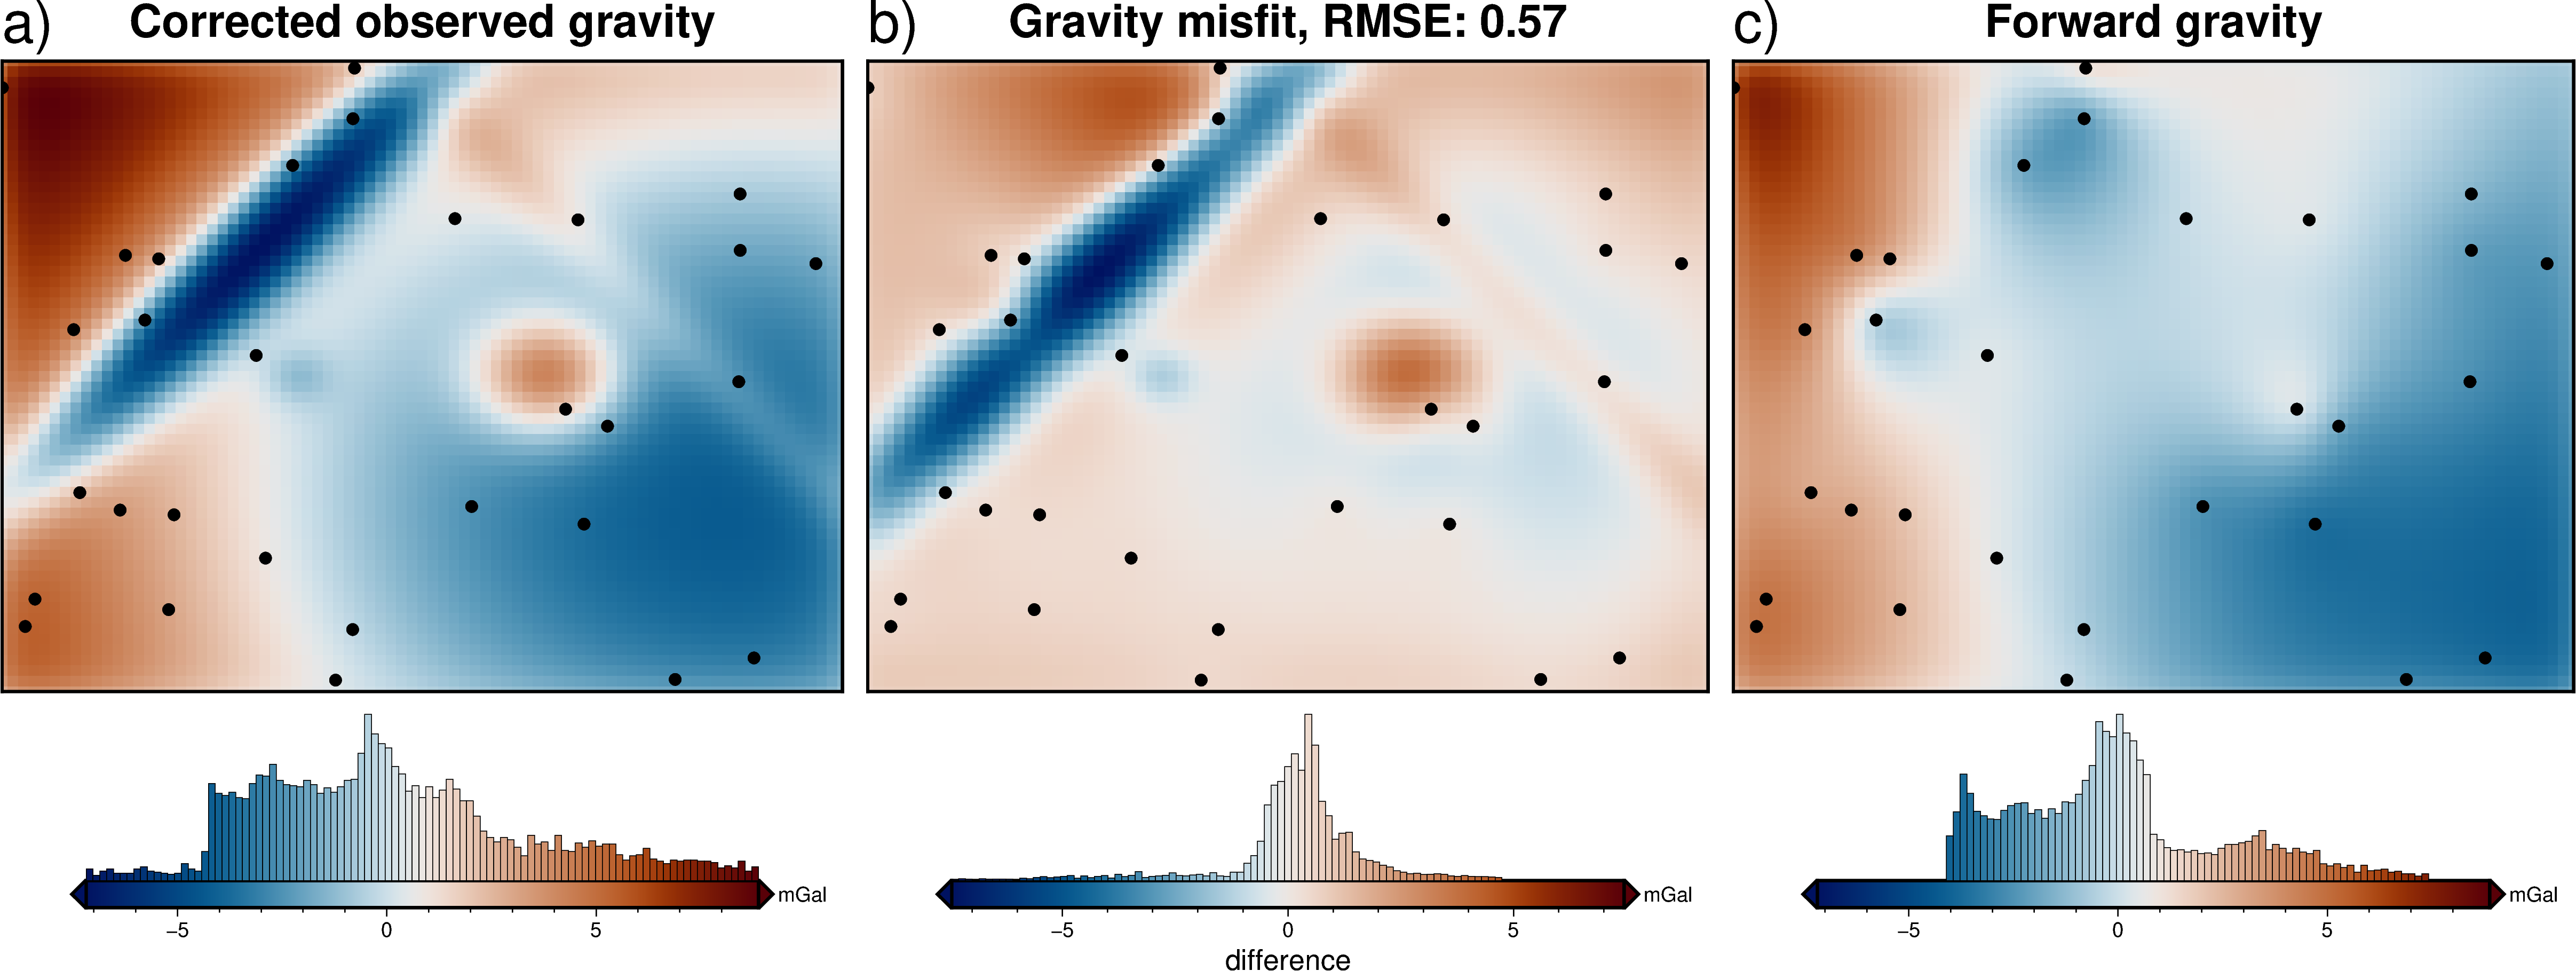

In [35]:
plotting.misfit_plotting(
    full_res_grav,
    grav_spacing=layer_spacing,
    plot_type="pygmt",
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr_shift",
    constraints=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

# Plot Inputs

In [36]:
# grid the residual misfit
residual = pygmt.surface(
    data=full_res_grav[["easting", "northing", "res"]],
    region=inversion_region,
    spacing=layer_spacing,
    T=0.25,
    # M="0c",
    registration=registration,
)

returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


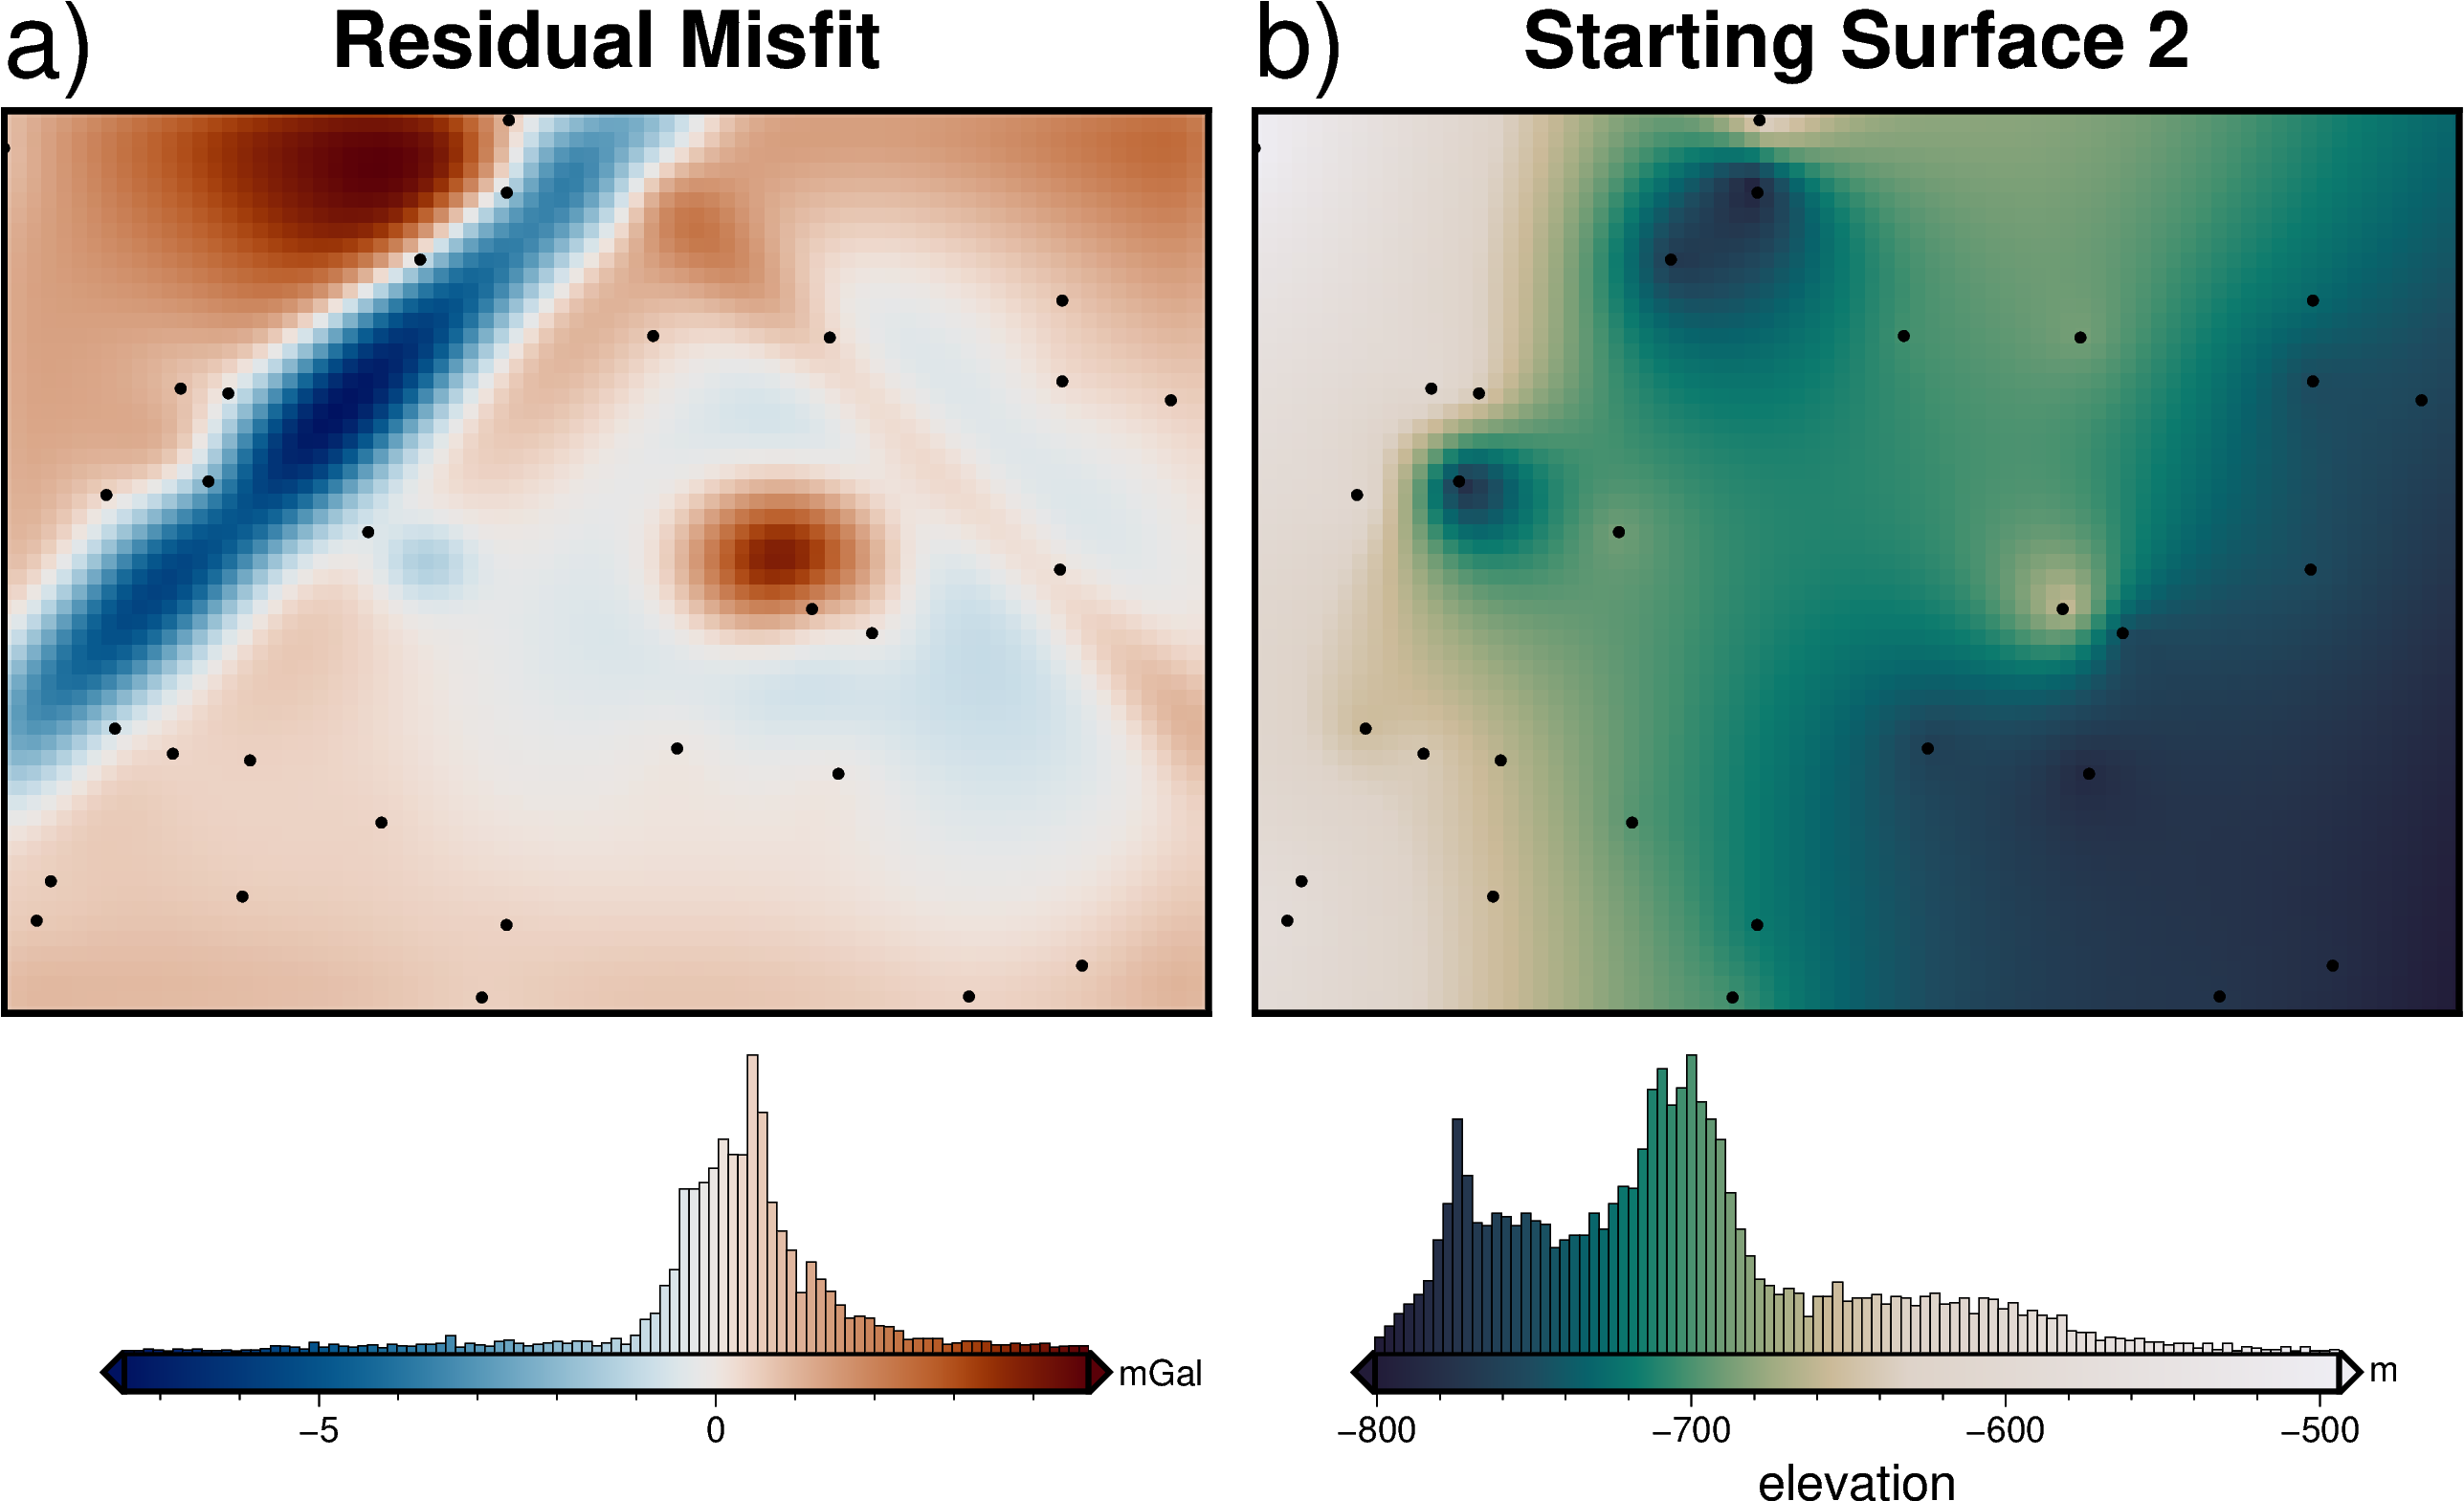

In [37]:
# plot residual misfit
fig = maps.plot_grd(
    grid=residual,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Residual Misfit",
    cbar_unit="mGal",
    show_region=inversion_region,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=lowres_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Starting Surface 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

fig.show()

# Constraints grid

In [38]:
layer_spacing

1000.0

In [11]:
starting_prisms = copy.deepcopy(layer2_prisms)

weights, min_dist = inv_utils.constraints_grid(
    constraint_points,  # .rename(columns={"easting":"x", "northing":"y"}),
    starting_prisms,  # .rename({"easting":"x", "northing":"y"}),#.drop_vars(("top", "bottom"))
    inner_bound=1e3,
    outer_bound=4e3,
    low=0,
    high=1,
    interp_type="spline",
    # tension_factor = .35,
    # plot = True,
)
starting_prisms["weights"] = weights.z
starting_prisms["min_dist"] = min_dist.min_dist
starting_prisms

<xarray.Dataset>
Dimensions:    (northing: 61, easting: 81)
Coordinates:
  * easting    (easting) float64 0.0 1e+03 2e+03 3e+03 ... 7.8e+04 7.9e+04 8e+04
  * northing   (northing) float64 0.0 1e+03 2e+03 ... 5.8e+04 5.9e+04 6e+04
    top        (northing, easting) float64 -587.2 -590.2 ... -703.3 -703.3
    bottom     (northing, easting) float64 -703.3 -703.3 ... -729.8 -732.0
Data variables:
    density    (northing, easting) int64 1383 1383 1383 ... -1383 -1383 -1383
    thickness  (northing, easting) float64 116.0 113.0 109.7 ... -26.56 -28.74
    weights    (northing, easting) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    min_dist   (northing, easting) float64 6.57e+03 6.307e+03 ... 1.597e+04
Attributes:
    coords_units:      meters
    properties_units:  SI

In [ ]:
starting_prisms.weights.plot(cmap="Blues")

### Save to Zarr

In [ ]:
enc = {x: {"compressor": zarr.Blosc()} for x in starting_prisms}
starting_prisms.to_zarr(
    "../synthetic_data/synthetic_starting_prisms.zarr",
    encoding=enc,
    mode="w",
)

In [11]:
starting_prisms = xr.open_zarr("../synthetic_data/synthetic_starting_prisms.zarr")

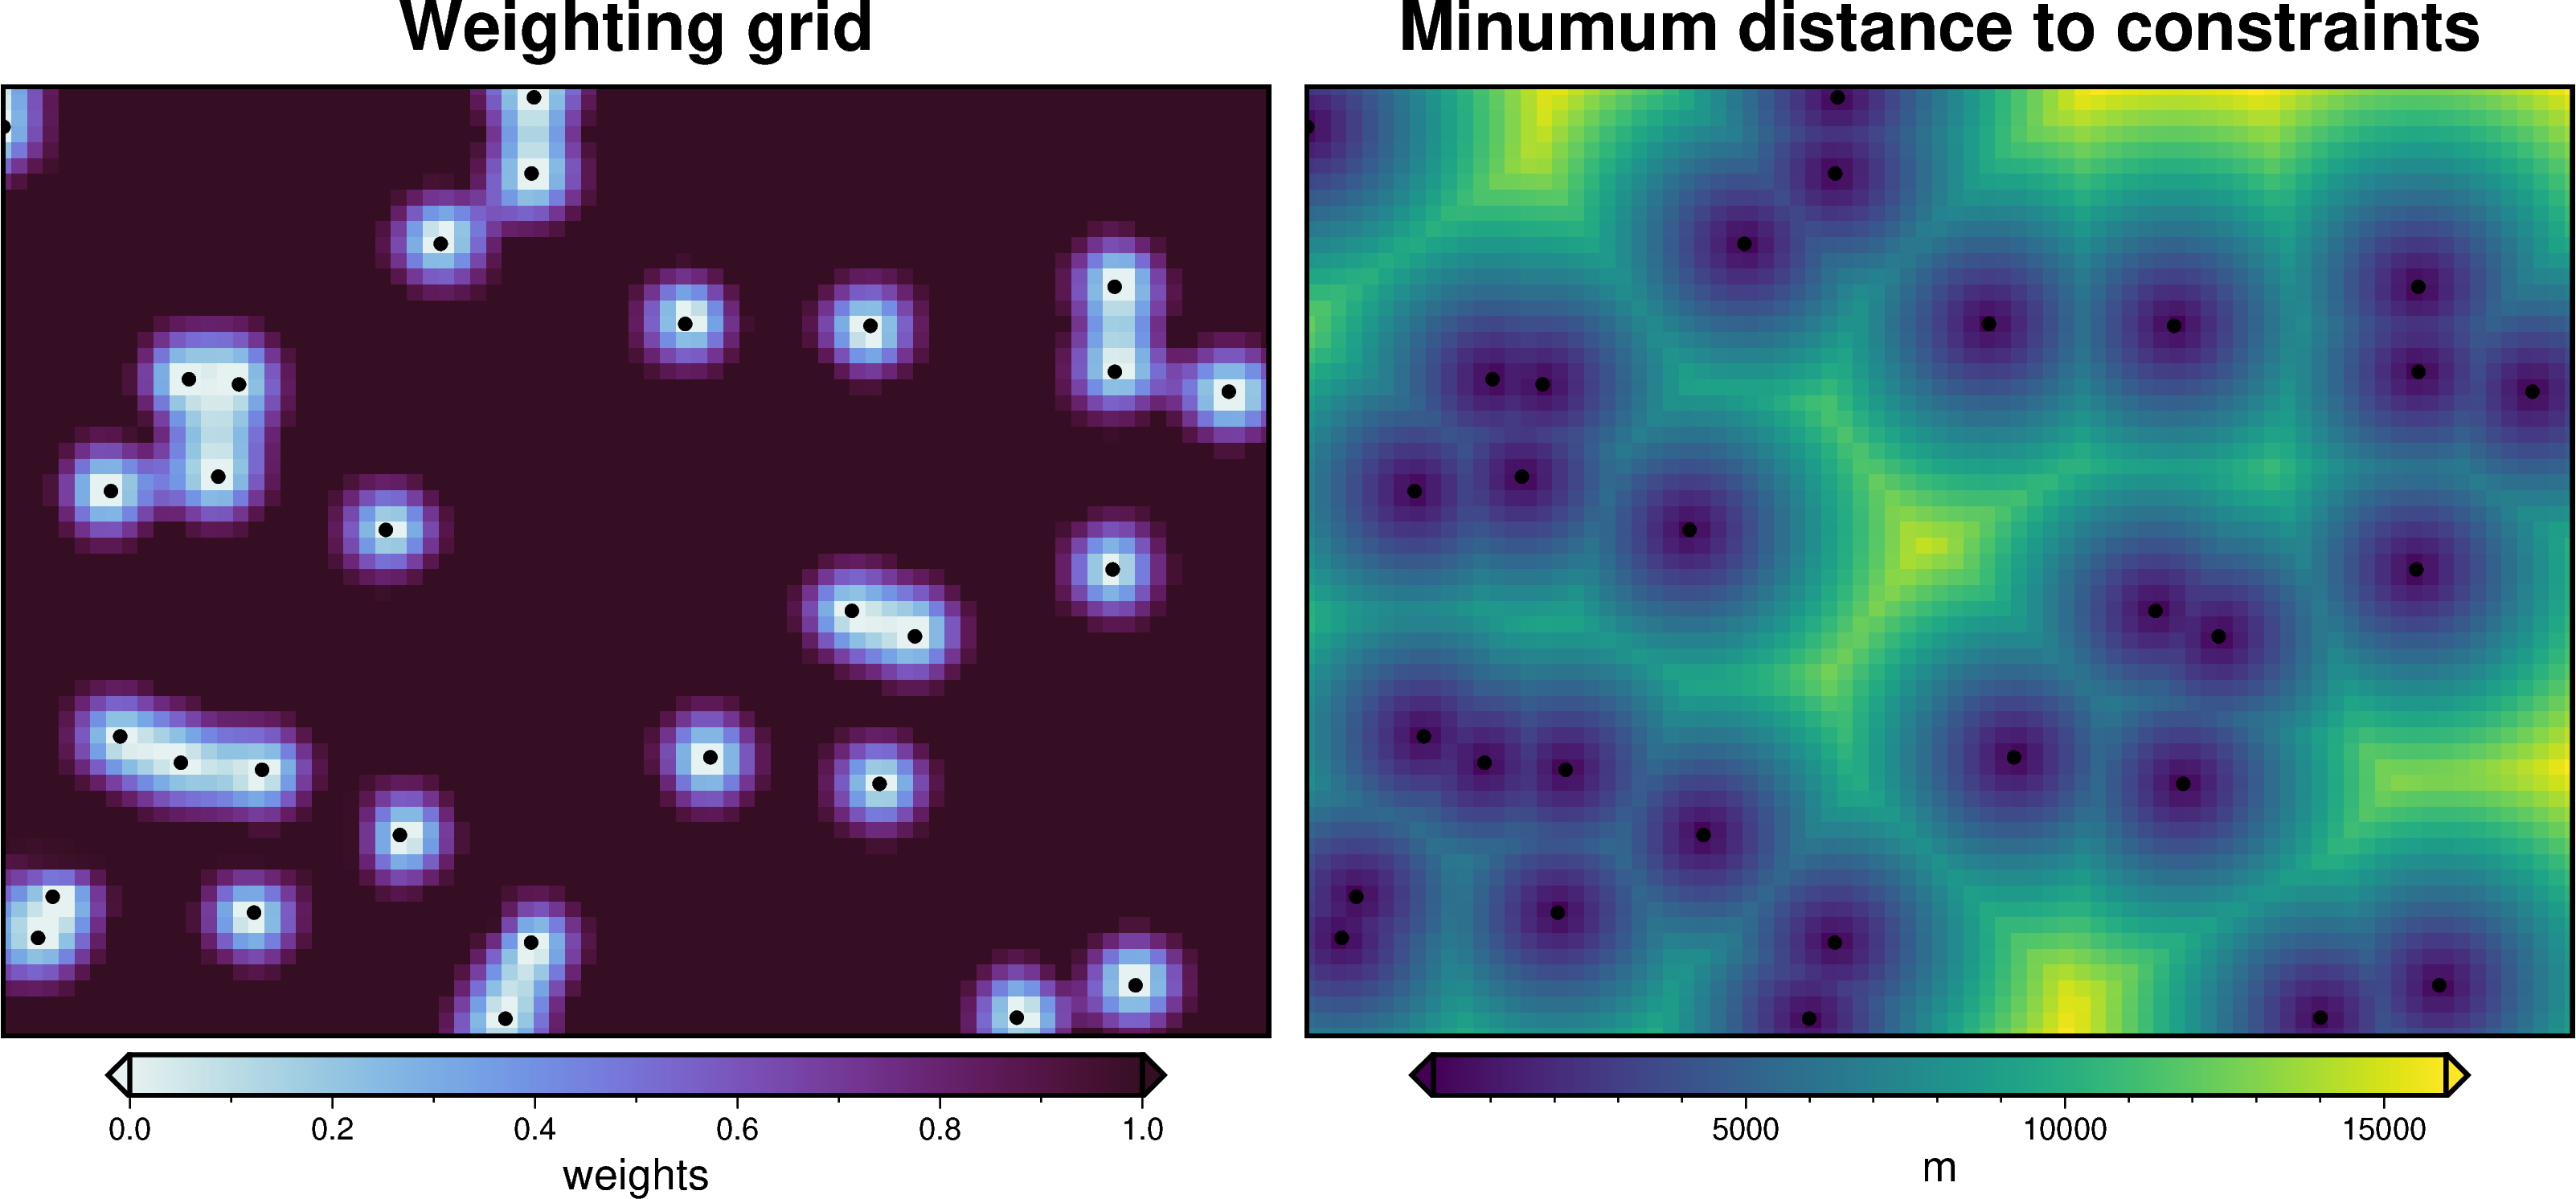

In [174]:
fig = maps.plot_grd(
    starting_prisms.weights,
    fig_height=10,
    title="Weighting grid",
    cbar_label="weights",
    cmap="dense",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.15c",
)
fig = maps.plot_grd(
    starting_prisms.min_dist,
    fig=fig,
    origin_shift="xshift",
    title="Minumum distance to constraints",
    cbar_label="m",
    cmap="viridis",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.15c",
)

fig.show()

# Inversion

Now that we have $G_{misfit}$, we can run an inversion to attempt to recover the true Layer 2 topography. Theres a number of parameters to choose from for the inversion.

## Testing weighting the Jacobian

In [213]:
surface_grid = xr.where(
    starting_prisms.density > 0, starting_prisms.top, starting_prisms.bottom
)
starting_prisms["surface"] = surface_grid

prisms_df = starting_prisms.to_dataframe().reset_index().dropna().astype(float)
prisms_df = inv_utils.sample_bounding_surfaces(
    prisms_df,
    upper_confining_layer=layer1,
    lower_confining_layer=None,
)
# where prisms are within 5km of constraint, set upper bounds to starting bed
prisms_df["upper_bounds"] = np.where(
    prisms_df.min_dist < 1e3, prisms_df.surface, prisms_df.upper_bounds
)
prisms_df["lower_bounds"] = np.where(
    prisms_df.min_dist < 1e3, prisms_df.surface, -np.inf
)
prisms_df

,northing,easting,bottom,density,min_dist,thickness,top,weights,surface,upper_bounds,lower_bounds
0,0.0,0.0,-703.251359,1383.0,6569.680665,116.029069,-587.222290,1.0,-587.222290,0.000000,-inf
1,0.0,1000.0,-703.251359,1383.0,6307.034891,113.028397,-590.222961,1.0,-590.222961,-14.544444,-inf
2,0.0,2000.0,-703.251359,1383.0,6196.505000,109.683183,-593.568176,1.0,-593.568176,-28.844444,-inf
3,0.0,3000.0,-703.251359,1383.0,6246.171571,106.019120,-597.232239,1.0,-597.232239,-42.900002,-inf
4,0.0,4000.0,-703.251359,1383.0,6452.336351,102.081559,-601.169800,1.0,-601.169800,-56.711113,-inf
...,...,...,...,...,...,...,...,...,...,...,...
4936,60000.0,76000.0,-723.190552,-1383.0,13889.599850,-19.939193,-703.251359,1.0,-723.190552,-408.711121,-inf
4937,60000.0,77000.0,-725.404053,-1383.0,14332.557140,-22.152694,-703.251359,1.0,-725.404053,-404.677765,-inf
4938,60000.0,78000.0,-727.610291,-1383.0,14829.814710,-24.358932,-703.251359,1.0,-727.610291,-400.399994,-inf
4939,60000.0,79000.0,-729.806824,-1383.0,15376.105311,-26.555465,-703.251359,1.0,-729.806824,-395.877777,-inf


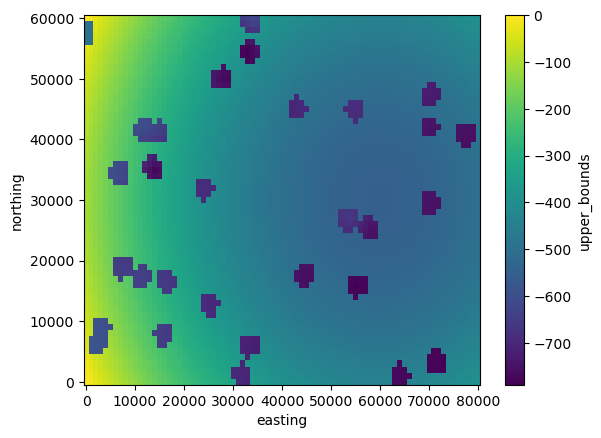

In [14]:
ds = prisms_df.set_index(["northing", "easting"]).to_xarray()
ds.upper_bounds.plot()

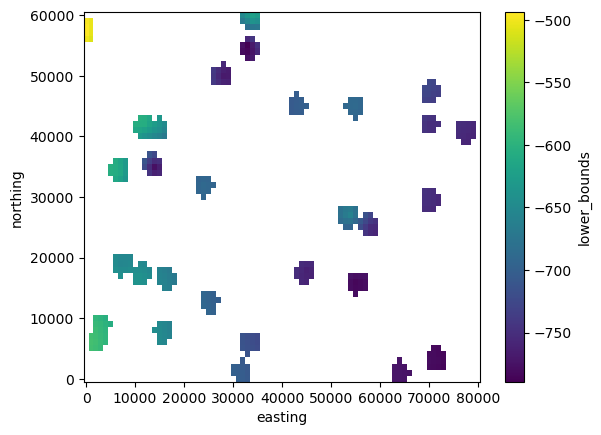

In [15]:
ds.lower_bounds.plot()

In [16]:
lower_bounds = np.array(prisms_df.lower_bounds)
upper_bounds = np.array(prisms_df.upper_bounds)


##############################################################################################
iteration 1
THE MODEL DID NOT CONVERGE
Layer correction median: 21 m, RMSE:40 m

updated misfit RMSE: 2.09
updated L2-norm: 1.44,  tolerance: 0.05
updated delta L2-norm : 0.52,  tolerance: 0.8

Inversion terminated after 1 iterations because L2 norm was more than 20% greater than starting L2 norm


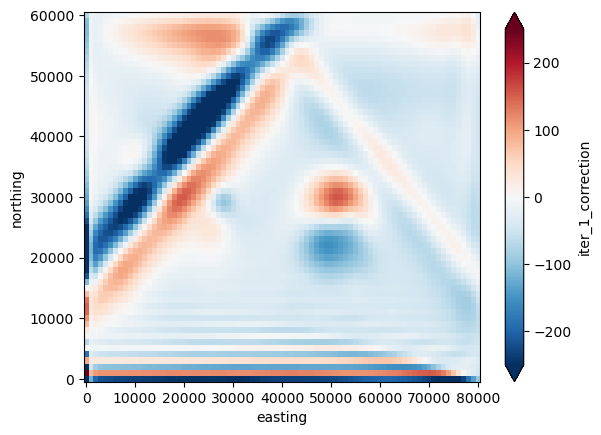

In [40]:
# set kwargs for inversion
inversion_kwargs = dict(
    input_grav=full_res_grav,
    input_grav_column="Gobs_corr_shift",
    prism_layer=starting_prisms,
    max_iterations=1,
    l2_norm_tolerance=0.05,
    delta_l2_norm_tolerance=0.8,
    apply_weights=False,
)

prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
    **inversion_kwargs,
    deriv_type="annulus",
    # deriv_type = "prisms",
    # solver_type = "verde least squares",
    # solver_type = "scipy least squares",
    solver_type="CLR",
    bounds=None,
    # solver_damping = 100000000000,
)
ds_no_bounds = prism_results.set_index(["northing", "easting"]).to_xarray()
ds_no_bounds.iter_1_correction.plot(robust=True)


##############################################################################################
iteration 1
THE MODEL DID NOT CONVERGE
Layer correction median: 0 m, RMSE:1 m

updated misfit RMSE: 0.5
updated L2-norm: 0.71,  tolerance: 0.05
updated delta L2-norm : 1.06,  tolerance: 0.8

Inversion terminated after 1 iterations with L2-norm = 0.71 because maximum number of iterations  (1) reached


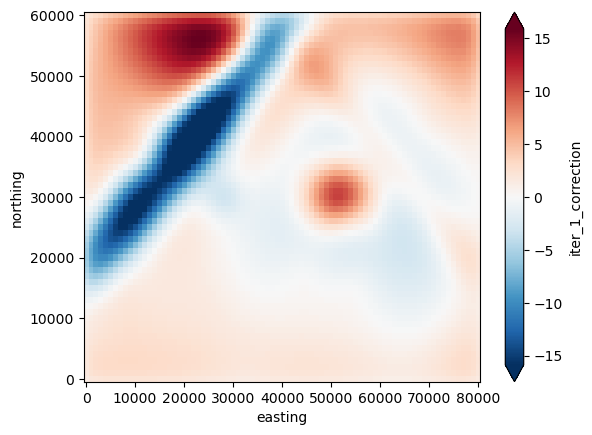

In [39]:
# set kwargs for inversion
inversion_kwargs = dict(
    input_grav=full_res_grav,
    input_grav_column="Gobs_corr_shift",
    prism_layer=starting_prisms,
    max_iterations=1,
    l2_norm_tolerance=0.05,
    delta_l2_norm_tolerance=0.8,
    apply_weights=False,
)

prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
    **inversion_kwargs,
    deriv_type="annulus",
    # deriv_type = "prisms",
    # solver_type = "verde least squares",
    # solver_type = "scipy least squares",
    solver_type="CLR",
    bounds=None,
    solver_damping=0.01,
)
ds_no_bounds = prism_results.set_index(["northing", "easting"]).to_xarray()
ds_no_bounds.iter_1_correction.plot(robust=True)


##############################################################################################
iteration 1
THE MODEL DID NOT CONVERGE
Layer correction median: -457 m, RMSE:457 m

updated misfit RMSE: 18.15
updated L2-norm: 4.26,  tolerance: 0.05
updated delta L2-norm : 0.18,  tolerance: 0.8

Inversion terminated after 1 iterations because L2 norm was more than 20% greater than starting L2 norm


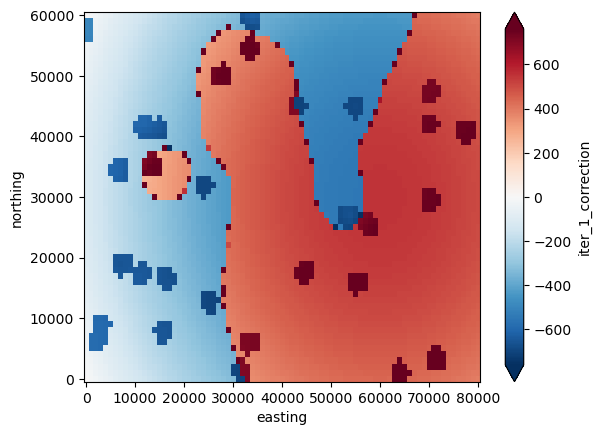

In [42]:
# set kwargs for inversion
inversion_kwargs = dict(
    input_grav=full_res_grav,
    input_grav_column="Gobs_corr_shift",
    prism_layer=starting_prisms,
    max_iterations=1,
    l2_norm_tolerance=0.05,
    delta_l2_norm_tolerance=0.8,
    apply_weights=False,
)

prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
    **inversion_kwargs,
    deriv_type="annulus",
    # deriv_type = "prisms",
    # solver_type = "verde least squares",
    # solver_type = "scipy least squares",
    solver_type="CLR",
    bounds=[lower_bounds, upper_bounds],
    # solver_damping = 100000000000,
)
ds_bounds = prism_results.set_index(["northing", "easting"]).to_xarray()
ds_bounds.iter_1_correction.plot(robust=True)


##############################################################################################
iteration 1
Layer correction median: -455 m, RMSE:455 m

updated misfit RMSE: 17.87
updated L2-norm: 4.23,  tolerance: 0.05
updated delta L2-norm : 0.18,  tolerance: 0.8

Inversion terminated after 1 iterations because L2 norm was more than 20% greater than starting L2 norm


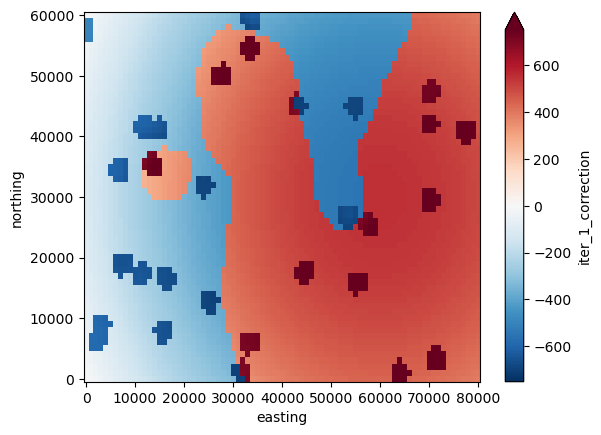

In [31]:
# set kwargs for inversion
inversion_kwargs = dict(
    input_grav=full_res_grav,
    input_grav_column="Gobs_corr_shift",
    prism_layer=starting_prisms,
    max_iterations=1,
    l2_norm_tolerance=0.05,
    delta_l2_norm_tolerance=0.8,
    apply_weights=False,
)

prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
    **inversion_kwargs,
    deriv_type="annulus",
    # deriv_type = "prisms",
    # solver_type = "verde least squares",
    # solver_type = "scipy least squares",
    solver_type="CLR",
    bounds=[lower_bounds, upper_bounds],
    solver_damping=10,
)
ds_bounds = prism_results.set_index(["northing", "easting"]).to_xarray()
ds_bounds.iter_1_correction.plot(robust=True)


##############################################################################################
iteration 1
THE MODEL DID NOT CONVERGE
Layer correction median: -455 m, RMSE:455 m

updated misfit RMSE: 17.87
updated L2-norm: 4.23,  tolerance: 0.05
updated delta L2-norm : 0.18,  tolerance: 0.8

Inversion terminated after 1 iterations because L2 norm was more than 20% greater than starting L2 norm


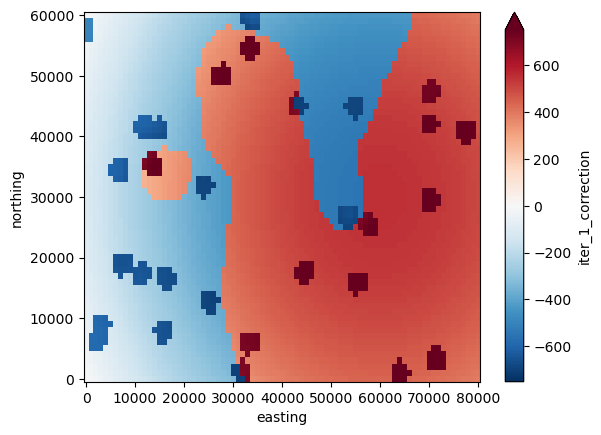

In [36]:
# set kwargs for inversion
inversion_kwargs = dict(
    input_grav=full_res_grav,
    input_grav_column="Gobs_corr_shift",
    prism_layer=starting_prisms,
    max_iterations=1,
    l2_norm_tolerance=0.05,
    delta_l2_norm_tolerance=0.8,
    apply_weights=False,
)

prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
    **inversion_kwargs,
    deriv_type="annulus",
    # deriv_type = "prisms",
    # solver_type = "verde least squares",
    # solver_type = "scipy least squares",
    solver_type="CLR",
    bounds=[lower_bounds, upper_bounds],
    solver_damping=0.001,
)
ds_bounds = prism_results.set_index(["northing", "easting"]).to_xarray()
ds_bounds.iter_1_correction.plot(robust=True)


##############################################################################################
iteration 1
Layer correction median: -455 m, RMSE:455 m

updated misfit RMSE: 17.87
updated L2-norm: 4.23,  tolerance: 0.05
updated delta L2-norm : 0.18,  tolerance: 0.8

Inversion terminated after 1 iterations because L2 norm was more than 20% greater than starting L2 norm


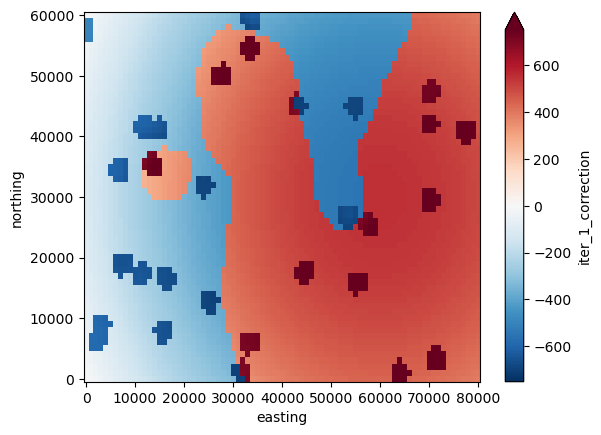

In [34]:
# set kwargs for inversion
inversion_kwargs = dict(
    input_grav=full_res_grav,
    input_grav_column="Gobs_corr_shift",
    prism_layer=starting_prisms,
    max_iterations=1,
    l2_norm_tolerance=0.05,
    delta_l2_norm_tolerance=0.8,
    apply_weights=False,
)

prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
    **inversion_kwargs,
    deriv_type="annulus",
    # deriv_type = "prisms",
    # solver_type = "verde least squares",
    # solver_type = "scipy least squares",
    solver_type="CLR",
    bounds=[lower_bounds * -np.inf, upper_bounds],
    solver_damping=10000,
)
ds_bounds = prism_results.set_index(["northing", "easting"]).to_xarray()
ds_bounds.iter_1_correction.plot(robust=True)

In [59]:
# _ = plotting.plot_inversion_results(
#     grav_results,
#     prism_results,
#     params,
#     grav_region=inversion_region,
#     grav_spacing=layer_spacing,
#     constraints=constraint_points,
#     # plot_iter_results=False
#     # plot_topo_results=False,
#     # plot_grav_results=False,
#     iters_to_plot=4,
#     )

In [176]:
# # set kwargs for inversion
# inversion_kwargs = dict(
#     input_grav = full_res_grav,
#     input_grav_column = 'Gobs_corr_shift',
#     prism_layer=starting_prisms,
#     max_iterations = 1,
#     l2_norm_tolerance = .05,
#     delta_l2_norm_tolerance = .8,
#     apply_weights = True,
# )

# prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
#     **inversion_kwargs,

#     deriv_type = "annulus",
#     # deriv_type = "prisms",

#     # solver_type = "verde least squares",
#     solver_type = "scipy least squares",

#     # solver_damping = 100000000000,
#         )
# ds_weights= prism_results.set_index(["northing","easting"]).to_xarray()
# ds_weights.iter_1_correction.plot(robust=True)

In [177]:
# _ = utils.grd_compare(
#     ds_no_weights.iter_1_correction,
#     ds_weights.iter_1_correction,
#     plot=True,
#     plot_type="xarray",
#     inset=False,
#     hist=True,
#     diff_lims=[-20,20],
# )

## with damping and multiple iterations

### w/o weights


##############################################################################################
iteration 1
Layer correction median: 6 m, RMSE:14 m

updated misfit RMSE: 0.04
updated L2-norm: 0.2,  tolerance: 0.05
updated delta L2-norm : 3.82,  tolerance: 0.8

##############################################################################################
iteration 2
Layer correction median: 0 m, RMSE:0 m

updated misfit RMSE: 0.0
updated L2-norm: 0.06,  tolerance: 0.05
updated delta L2-norm : 3.28,  tolerance: 0.8

##############################################################################################
iteration 3
Layer correction median: 0 m, RMSE:0 m

updated misfit RMSE: 0.0
updated L2-norm: 0.05,  tolerance: 0.05
updated delta L2-norm : 1.31,  tolerance: 0.8

Inversion terminated after 3 iterations with L2-norm = 0.05 because L2-norm < 0.05
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


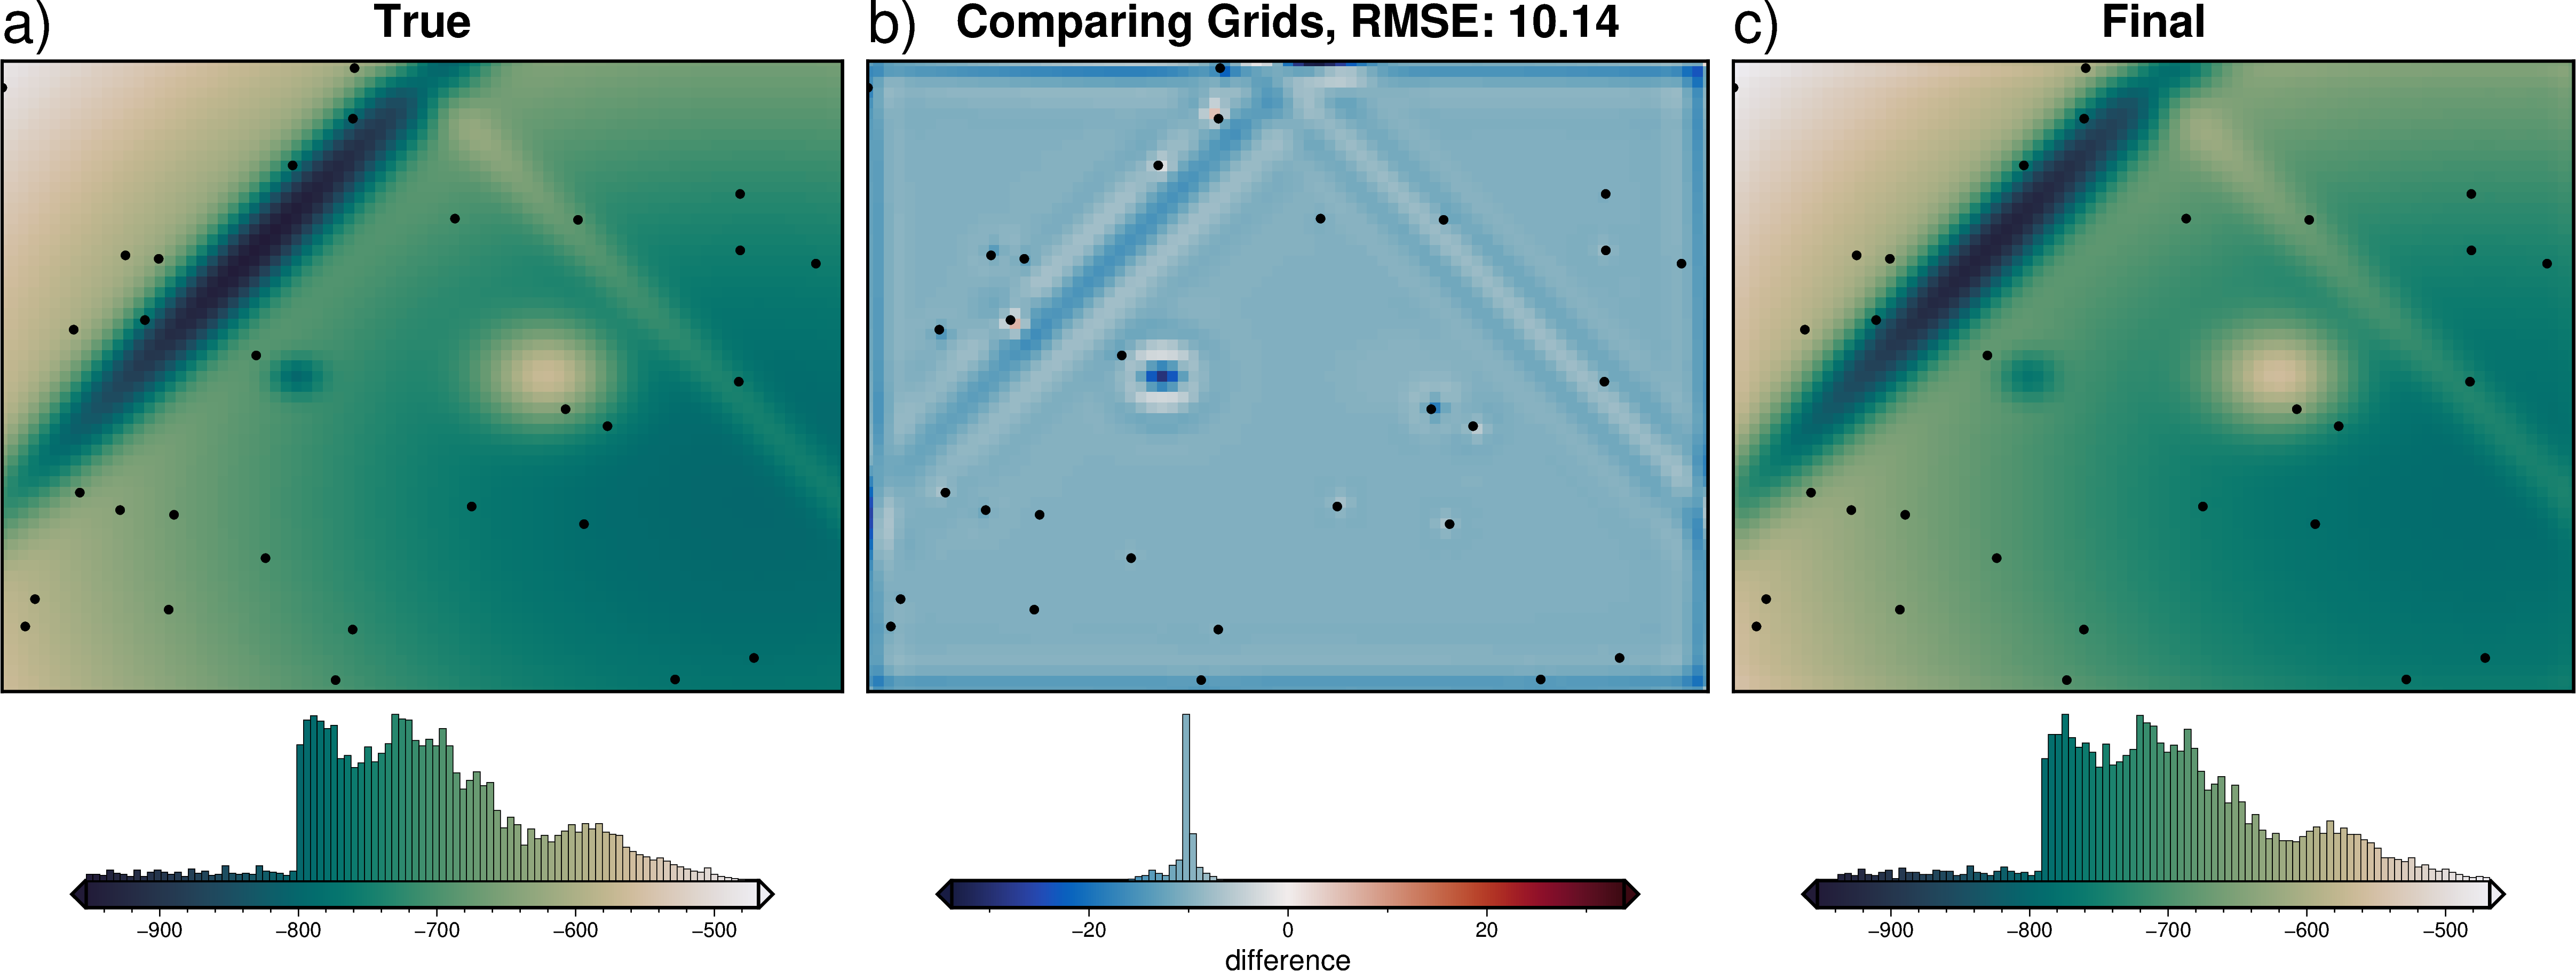

RMSE: 10.144938933073263
constraints RMSE: 10.37


In [11]:
# set kwargs for inversion
inversion_kwargs = dict(
    input_grav=full_res_grav,
    input_grav_column="Gobs_corr_shift",
    prism_layer=starting_prisms,
    max_iterations=10,
    l2_norm_tolerance=0.05,
    delta_l2_norm_tolerance=0.8,
    apply_weights=False,
)

no_weights_results = inv.inversion_RMSE(
    layer2,
    plot=True,
    constraints=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    deriv_type="annulus",
    # deriv_type = "prisms",
    # solver_type = "verde least squares",
    solver_type="scipy least squares",
    solver_damping=0.01,
    **inversion_kwargs,
)

(
    no_weights_rmse,
    no_weights_prism_results,
    no_weights_grav_results,
    no_weights_params,
    no_weights_elapsed_time,
    no_weights_constraints_rmse,
) = no_weights_results

print(f"RMSE: {no_weights_rmse}")
print(f"constraints RMSE: {no_weights_constraints_rmse}")

returning original grid
returning original grid
returning original grid
returning original grid


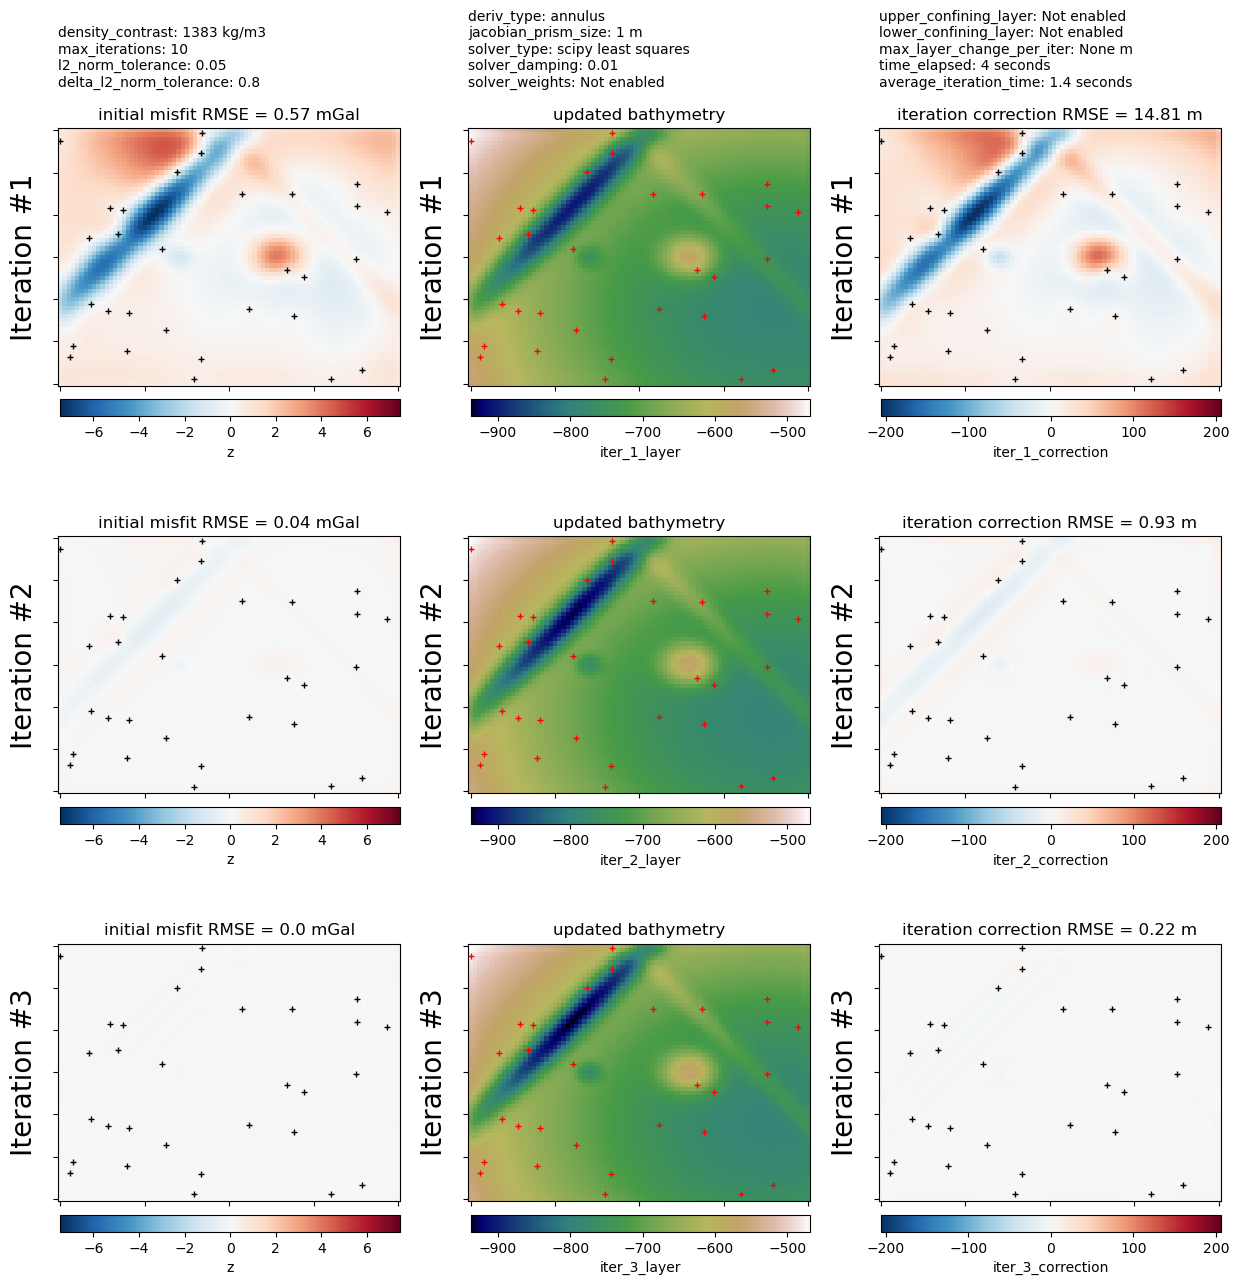

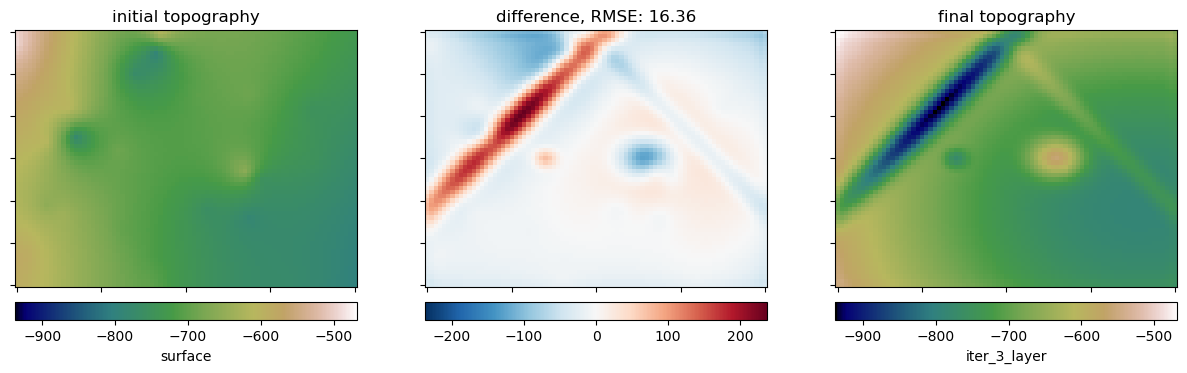

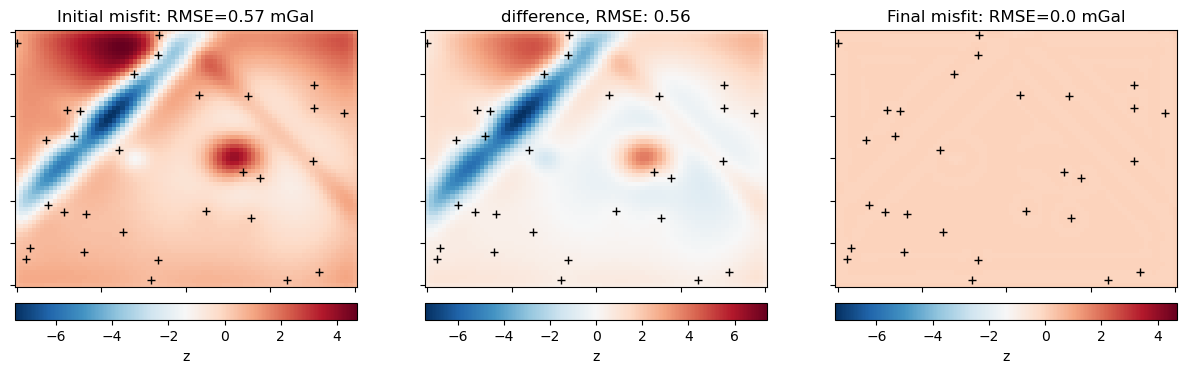

In [12]:
no_weights_grids = plotting.plot_inversion_results(
    no_weights_grav_results,
    no_weights_prism_results,
    no_weights_params,
    grav_region=inversion_region,
    grav_spacing=layer_spacing,
    constraints=constraint_points,
    # plot_iter_results=False
    # plot_topo_results=False,
    # plot_grav_results=False,
    iters_to_plot=4,
)

In [17]:
no_weights_ds = no_weights_prism_results.set_index(["northing", "easting"]).to_xarray()
print(f"max iter: {list(no_weights_ds.variables)[-1][5:-6]}")
no_weights_final_topo = no_weights_ds[list(no_weights_ds.variables)[-1]]

max iter: 3


### w/ weights


##############################################################################################
iteration 1
Layer correction median: 4 m, RMSE:15 m

updated misfit RMSE: 0.05
updated L2-norm: 0.23,  tolerance: 0.05
updated delta L2-norm : 3.26,  tolerance: 0.8

##############################################################################################
iteration 2
Layer correction median: 0 m, RMSE:1 m

updated misfit RMSE: 0.01
updated L2-norm: 0.1,  tolerance: 0.05
updated delta L2-norm : 2.42,  tolerance: 0.8

##############################################################################################
iteration 3
Layer correction median: 0 m, RMSE:0 m

updated misfit RMSE: 0.01
updated L2-norm: 0.08,  tolerance: 0.05
updated delta L2-norm : 1.2,  tolerance: 0.8

##############################################################################################
iteration 4
Layer correction median: 0 m, RMSE:0 m

updated misfit RMSE: 0.0
updated L2-norm: 0.07,  tolerance: 0.05
updated 

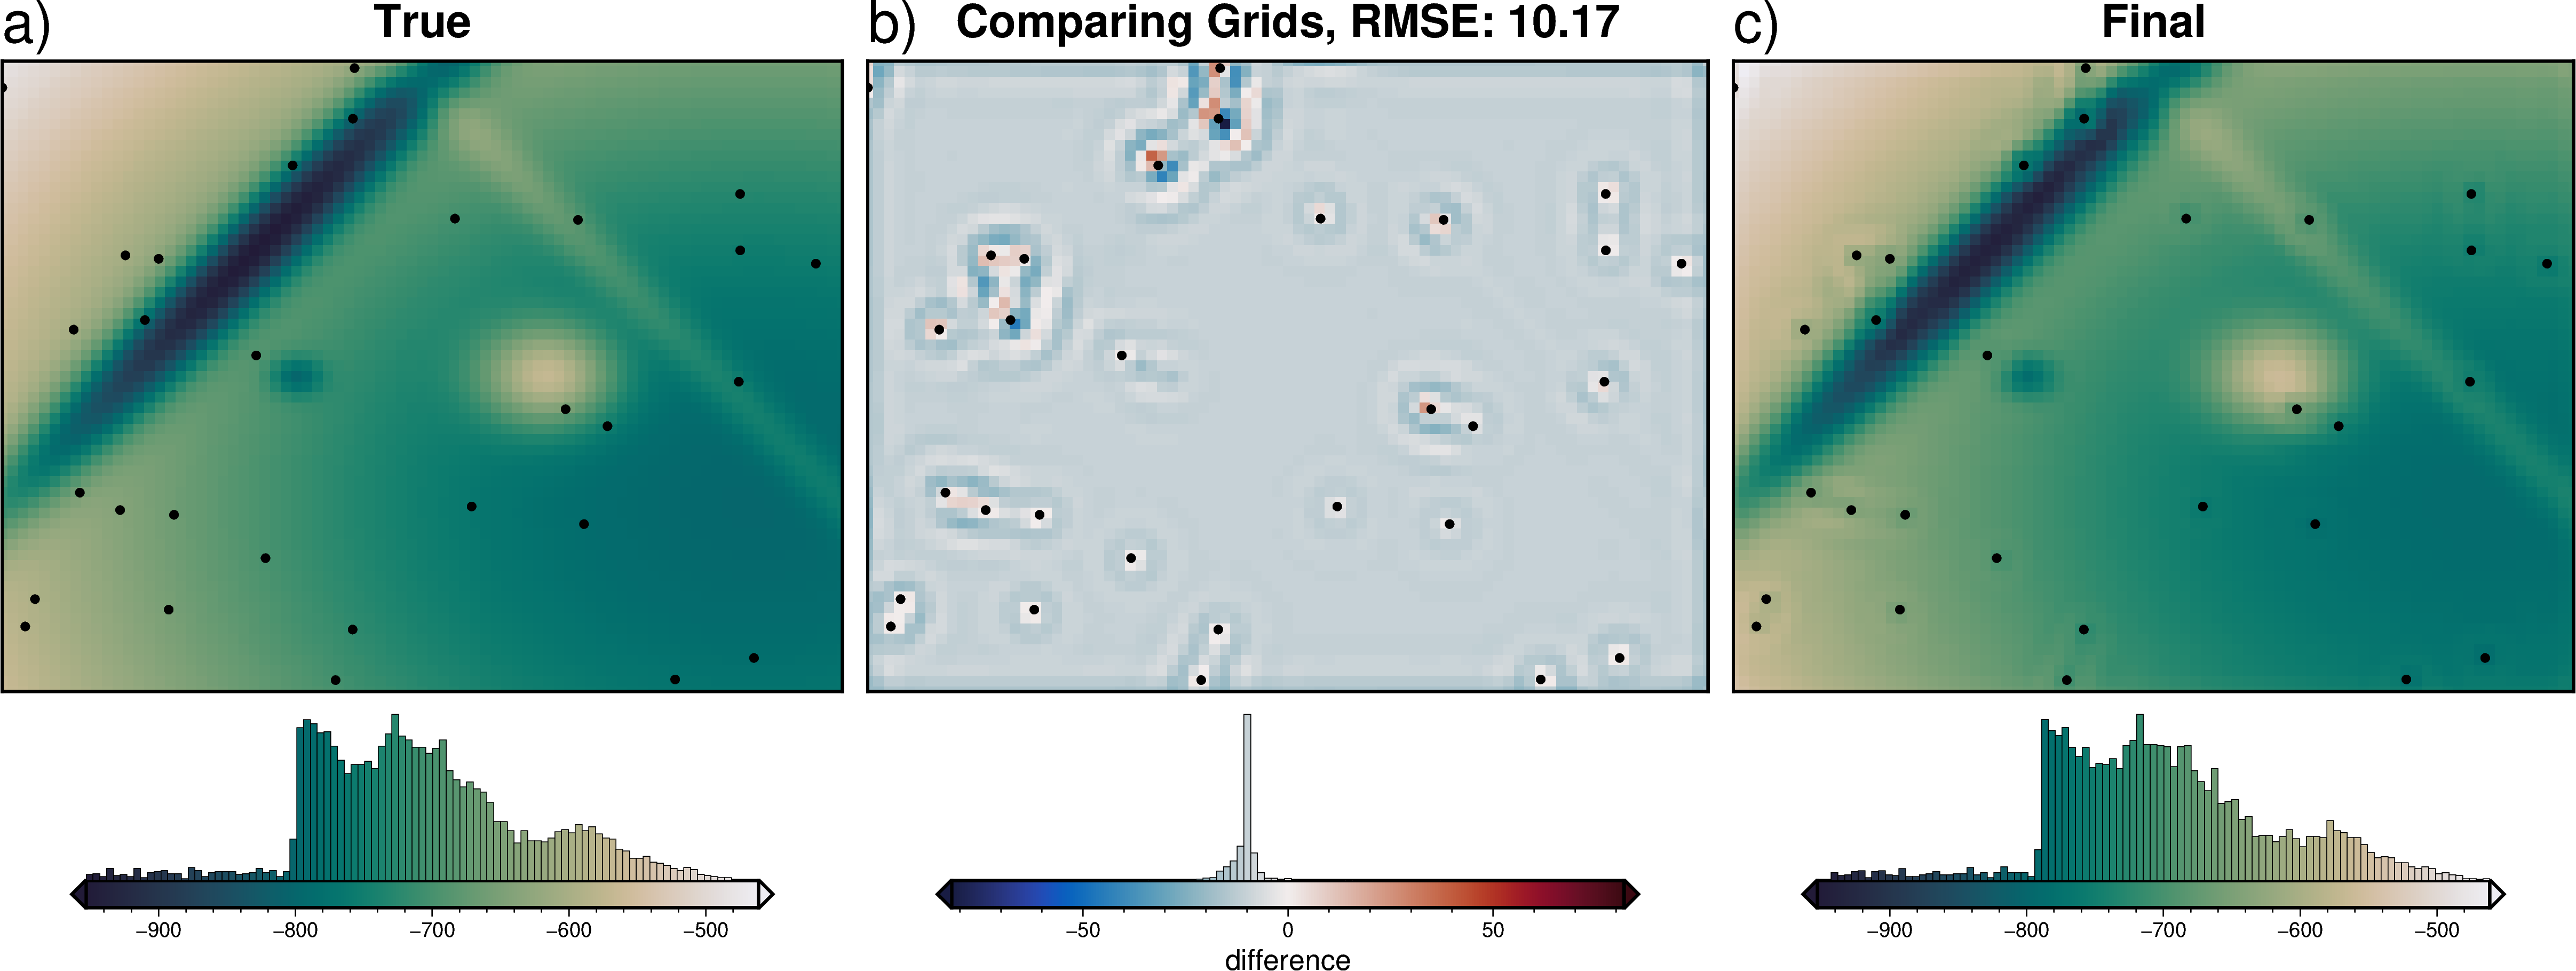

RMSE: 10.171328458532685
constraints RMSE: 2.83


In [14]:
# set kwargs for inversion
inversion_kwargs = dict(
    input_grav=full_res_grav,
    input_grav_column="Gobs_corr_shift",
    prism_layer=starting_prisms,
    max_iterations=10,
    l2_norm_tolerance=0.05,
    delta_l2_norm_tolerance=0.8,
    apply_weights=True,
)

weights_results = inv.inversion_RMSE(
    layer2,
    plot=True,
    constraints=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    deriv_type="annulus",
    # deriv_type = "prisms",
    # solver_type = "verde least squares",
    solver_type="scipy least squares",
    solver_damping=0.01,
    **inversion_kwargs,
)

(
    weights_rmse,
    weights_prism_results,
    weights_grav_results,
    weights_params,
    weights_elapsed_time,
    weights_constraints_rmse,
) = weights_results

print(f"RMSE: {weights_rmse}")
print(f"constraints RMSE: {weights_constraints_rmse}")

In [18]:
weights_ds = weights_prism_results.set_index(["northing", "easting"]).to_xarray()
print(f"max iter: {list(weights_ds.variables)[-1][5:-6]}")
weights_final_topo = weights_ds[list(weights_ds.variables)[-1]]

max iter: 8


returning original grid
returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


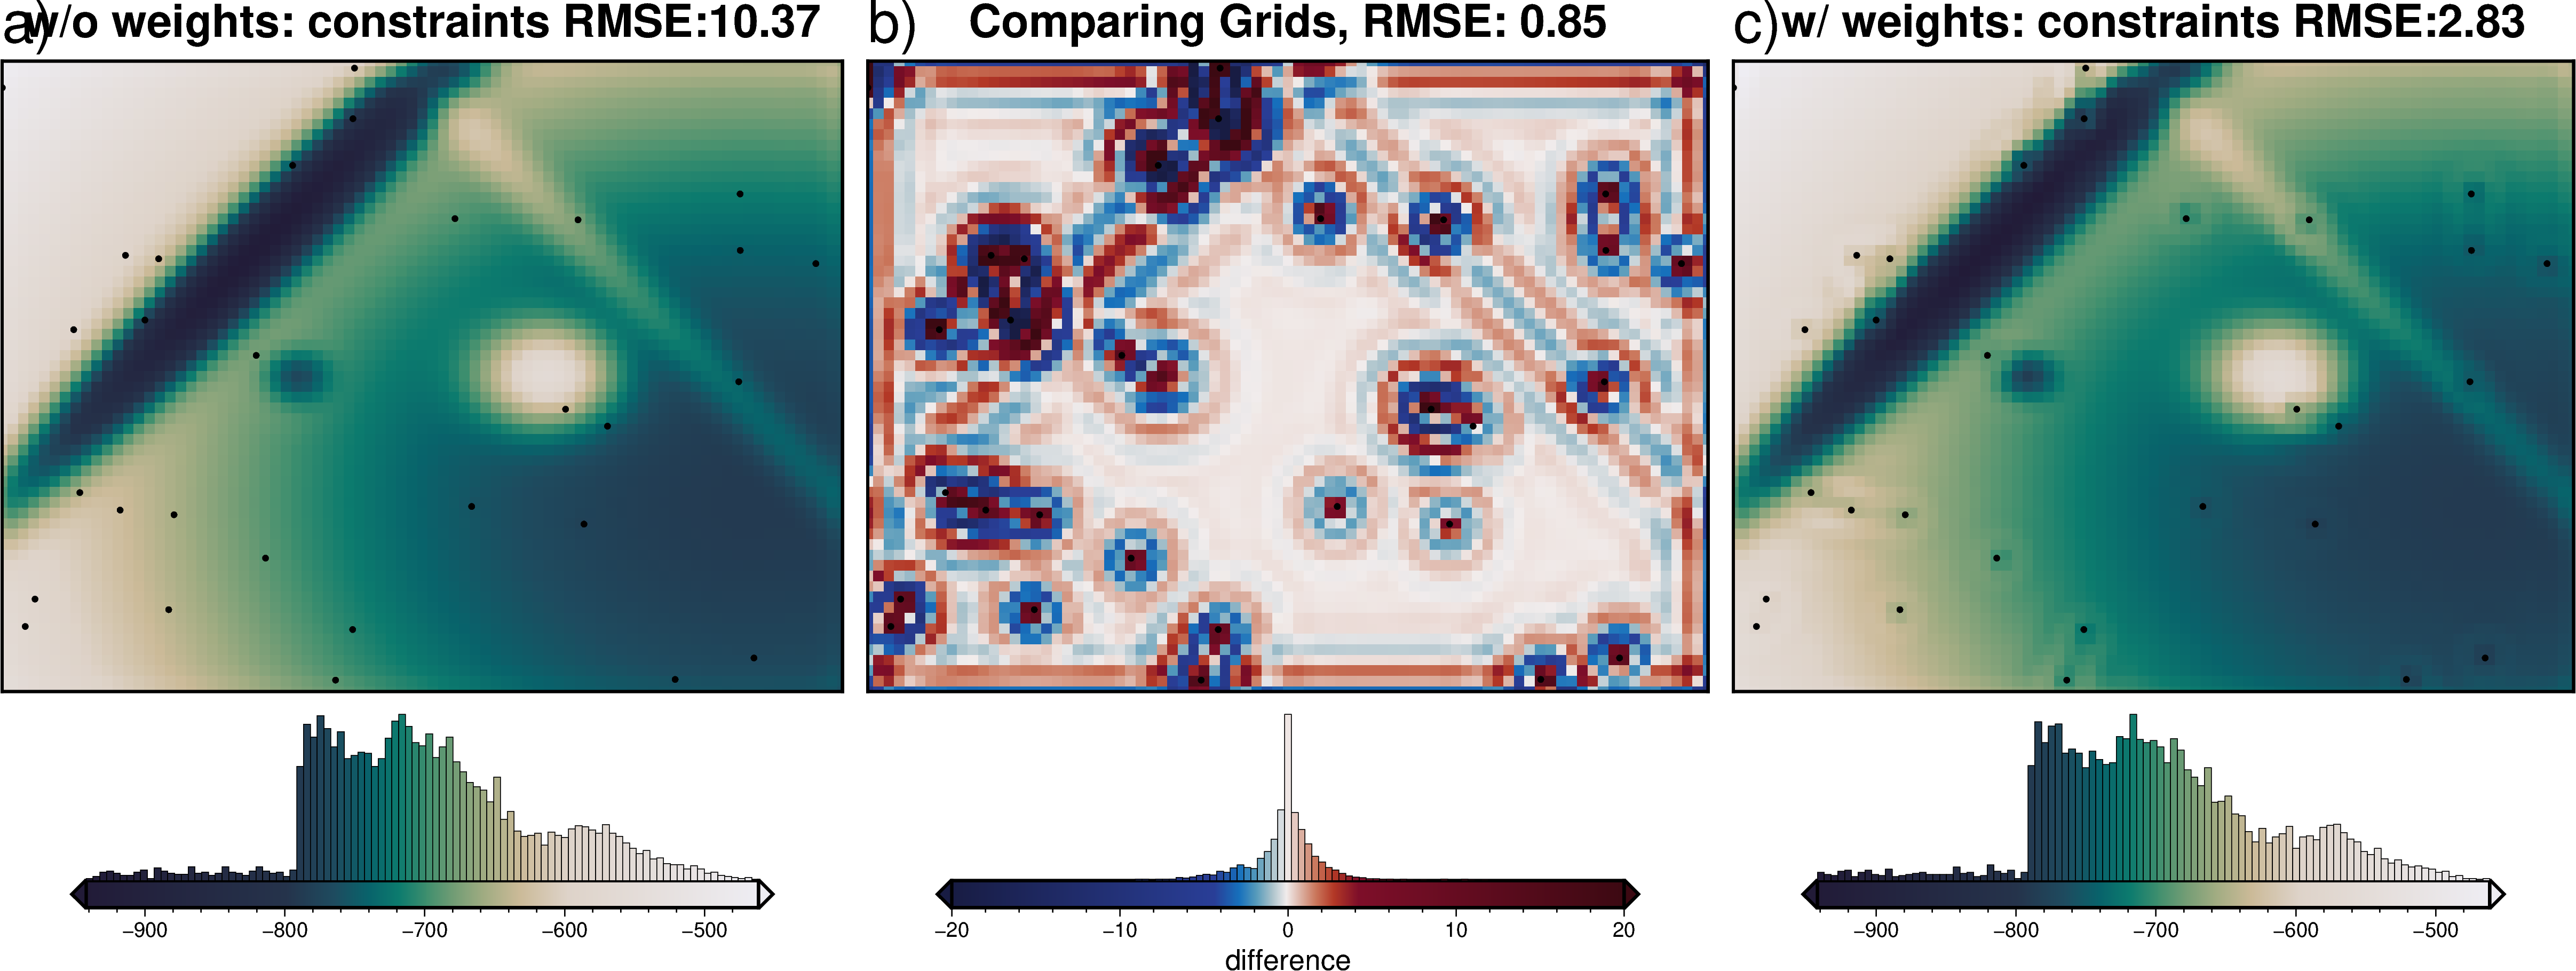

In [19]:
_ = utils.grd_compare(
    no_weights_final_topo,
    weights_final_topo,
    grid1_name=f"w/o weights: constraints RMSE:{no_weights_constraints_rmse}",
    grid2_name=f"w/ weights: constraints RMSE:{weights_constraints_rmse}",
    plot=True,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    diff_lims=[-20, 20],
    # plot_type="xarray",
    # cmap="gist_earth",
    # robust=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    hist=True,
    inset=False,
    points_style="c.1c",
    subplot_labels=True,
    grd2cpt=True,
)

In [263]:
# results = inv.inversion_RMSE(
#     layer2,
#     plot=True,
#     deriv_type = "annulus",
#     # deriv_type = "prisms",
#     solver_type = "verde least squares",
#     # solver_type = "scipy least squares",
#     # solver_damping = 100000,
#     constraints = constraint_points,#.rename(columns = {"easting":"x","northing":"y"}),
#     **inversion_kwargs,
#     )
# (
# rmse,
# prism_results,
# grav_results,
# params,
# elapsed_time,
# constraints_rmse) = results

# print(f"RMSE: {rmse}")
# print(f"constraints RMSE: {constraints_rmse}")

In [254]:
# grids = plotting.plot_inversion_results(
#     grav_results,
#     prism_results,
#     params,
#     grav_region=inversion_region,
#     grav_spacing=layer_spacing,
#     constraints=constraint_points,
#     # plot_iter_results=False
#     # plot_topo_results=False,
#     # plot_grav_results=False,
#     iters_to_plot=4,
#     )

In [20]:
# # %%snakeviz
# prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
#     **inversion_kwargs,

#     deriv_type = "annulus",
#     # deriv_type = "prisms",

#     solver_type = "verde least squares",
#     # solver_type = "scipy least squares",

#     # solver_damping = 100000,
#         )

In [19]:
# grids = plotting.plot_inversion_results(
#     grav_results,
#     prism_results,
#     params,
#     grav_region=inversion_region,
#     grav_spacing=layer_spacing,
#     constraints=constraint_points,
#     # plot_iter_results=False
#     # plot_topo_results=False,
#     # plot_grav_results=False,
#     iters_to_plot=4,
#     )

# Optimize the inversion

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Jacobian methods (annulus vs small prisms)
* Solver methods (Scipy lsqr vs Verde lsqr)
* Solver damping
* max prism change per iteration

In [ ]:
# set name and storage for the optimization
study_name = "2layer_inversion_params"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials = 100

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# # create study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     directions=directions,
#     # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#     sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#     load_if_exists=True,
#     )

# # define the objective function
# objective_func = optimization.optimal_inversion_params(
#     true_layer2,
#     verde_damping_limits = [0, 1e4],
#     scipy_damping_limits = [0, 1],
#     objectives = objectives,
#     constraints = constraint_points,
#     **no_noise_kwargs)

# # run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = optimization.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#     )

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)

plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    include_duration=True,
)

In [ ]:
df_all = study.trials_dataframe()
start = df_all.sort_values(by="datetime_start").iloc[0].datetime_start
stop = (
    df_all.sort_values(by="datetime_complete", ascending=False)
    .iloc[0]
    .datetime_complete
)

time = stop - start
print(f"Total time for optimizaiton: {time.total_seconds()/60} minutes")

# df_all.sort_values(by="value")[0:20]

In [ ]:
(
    df,
    best_verde,
    best_scipy,
    best_prisms,
    best_annulus,
) = optimization.get_best_of_each_param(study, objectives)
# df.sort_values(by=["RMSE", "constraints", "duration"], inplace=True)
df

In [ ]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **no_noise_kwargs
)

In [ ]:
ind = [trial.number for trial in study.trials].index(best_annulus)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **no_noise_kwargs
)

In [ ]:
ind = [trial.number for trial in study.trials].index(best_verde)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **no_noise_kwargs
)

# Repeat with noise

The above inversion was able to fully recover Layer 2. This is expected, since there was no noise in the data, and we used a very simple 2 layer model to create the observed gravity. Next we add 2% gaussian noise to $G_{misfit}$ to see how the inversion performs.

In [488]:
df_anomalies_noise = df_anomalies.copy()

df_anomalies_noise["res"] = synth.contaminate(
    df_anomalies_noise.res,
    stddev=0.02,
    percent=True,
    seed=0,
)
df_anomalies_noise

,x,y,lat,lon,station_ID,z,geoidal_elevation,elevation_error,observed_gravity,observed_gravity_error,gravity_disturbance,gravity_disturbance_error,Gobs,free_air_anomaly_error,layer1_forward,Gobs_corr,layer2_forward,misfit,reg,res
0,0.0,0.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,10.581479,NaN,7.079618,3.117193,2.445618,0.671575,0,0.937134
1,1000.0,0.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,12.551074,NaN,8.411450,3.754956,2.974444,0.780512,0,0.842796
2,2000.0,0.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,13.172549,NaN,8.769055,4.018826,3.201610,0.817216,0,0.965732
3,3000.0,0.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,13.253567,NaN,8.776992,4.091908,3.268290,0.823618,0,1.160245
4,4000.0,0.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,13.104524,NaN,8.645779,4.074078,3.253918,0.820159,0,1.101145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4936,76000.0,60000.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,3.023554,NaN,1.019056,1.619829,-0.349516,1.969345,0,1.919871
4937,77000.0,60000.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,3.088488,NaN,1.105780,1.598040,-0.382226,1.980266,0,1.882941
4938,78000.0,60000.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,3.132262,NaN,1.194986,1.552608,-0.393327,1.945936,0,1.806011
4939,79000.0,60000.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,3.120086,NaN,1.282108,1.453309,-0.362025,1.815335,0,1.907096


In [489]:
# set kwargs for inversion
inversion_noise_kwargs = dict(
    input_grav=df_anomalies_noise,
    input_grav_column="Gobs_corr",
    prism_layer=layer2_prisms,
    max_iterations=10,
    l2_norm_tolerance=0.2,
    delta_l2_norm_tolerance=0.8,
)

In [ ]:
# set name and storage for the optimization
study_name = "2layer_inversion_noise_params"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials = 100

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# # create study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     directions=directions,
#     # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#     sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#     load_if_exists=True,
#     )

# # define the objective function
# objective_func = optimization.optimal_inversion_params(
#     true_layer2,
#     verde_damping_limits = [0, 1e4],
#     scipy_damping_limits = [0, 1],
#     objectives = objectives,
#     constraints = constraint_points,
#     **noise_kwargs)

# # run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = optimization.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#     )

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)

plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    include_duration=True,
)

In [ ]:
df_all = study.trials_dataframe()
start = df_all.sort_values(by="datetime_start").iloc[0].datetime_start
stop = (
    df_all.sort_values(by="datetime_complete", ascending=False)
    .iloc[0]
    .datetime_complete
)

time = stop - start
print(f"Total time for optimizaiton: {time.total_seconds()/60} minutes")

# df_all.sort_values(by="value")[0:20]

In [ ]:
(
    df,
    best_verde,
    best_scipy,
    best_prisms,
    best_annulus,
) = optimization.get_best_of_each_param(study, objectives)
# df.sort_values(by=["RMSE", "constraints", "duration"], inplace=True)
df

In [ ]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **noise_kwargs
)

In [ ]:
ind = [trial.number for trial in study.trials].index(best_annulus)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **noise_kwargs
)

In [ ]:
ind = [trial.number for trial in study.trials].index(best_verde)
best_params = study.trials[ind].params
print(best_params)

plotting.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    **noise_kwargs
)

# Repeat with synthetic survey

## Ice gravity

In [151]:
# calculate gravity of layer1
layer1_grav_grid, layer1_grav_df = inv_utils.forward_grav_of_prismlayer(
    [layer1_prisms],
    sampled_grav,
    names=["layer1_prisms"],
    remove_median=False,
    progressbar=True,
    plot=False,
)

sampled_grav["layer1_forward"] = layer1_grav_df.forward_total

# subtract from observed gravity
sampled_grav["Gobs_corr"] = sampled_grav.Gobs - sampled_grav.layer1_forward

# center on 0
# full_res_grav['Gobs_corr'] -= full_res_grav['Gobs_corr'].median()

# grid the results
layer1_forward = (
    sampled_grav.set_index(["northing", "easting"]).to_xarray().layer1_forward
)
Gobs_corr = sampled_grav.set_index(["northing", "easting"]).to_xarray().Gobs_corr

# center on 0
# layer1_forward -= np.median(layer1_forward)
# Gobs_corr -= np.median(Gobs_corr)
sampled_grav

  0%|                                                  | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,Gobs,layer1_forward,Gobs_corr
0,0.0,0.0,1000.0,978040.1250,5.504590,978034.620410
1,0.0,2000.0,1000.0,978042.6875,7.194027,978035.493473
2,0.0,4000.0,1000.0,978042.6250,7.070751,978035.554249
3,0.0,6000.0,1000.0,978042.0625,6.646541,978035.415959
4,0.0,8000.0,1000.0,978041.3125,6.145260,978035.167240
...,...,...,...,...,...,...
1266,60000.0,72000.0,1000.0,978032.3125,-0.856916,978033.169416
1267,60000.0,74000.0,1000.0,978032.4375,-0.716487,978033.153987
1268,60000.0,76000.0,1000.0,978032.5625,-0.555972,978033.118472
1269,60000.0,78000.0,1000.0,978032.6875,-0.380042,978033.067542


## Bed gravity

In [153]:
# calculate gravity of layer1
layer2_grav_grid, layer2_grav_df = inv_utils.forward_grav_of_prismlayer(
    [layer2_prisms],
    sampled_grav,
    names=["layer2_prisms"],
    remove_median=False,
    progressbar=True,
    plot=False,
)

sampled_grav["layer2_forward"] = layer2_grav_df.forward_total

# grid the results
layer2_forward = (
    sampled_grav.set_index(["northing", "easting"]).to_xarray().layer2_forward
)

# center on 0
# layer2_forward -= np.median(layer2_forward)

sampled_grav

  0%|                                                  | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,Gobs,layer1_forward,Gobs_corr,layer2_forward
0,0.0,0.0,1000.0,978040.1250,5.504590,978034.620410,2.172211
1,0.0,2000.0,1000.0,978042.6875,7.194027,978035.493473,2.928203
2,0.0,4000.0,1000.0,978042.6250,7.070751,978035.554249,2.980512
3,0.0,6000.0,1000.0,978042.0625,6.646541,978035.415959,2.835162
4,0.0,8000.0,1000.0,978041.3125,6.145260,978035.167240,2.618552
...,...,...,...,...,...,...,...
1266,60000.0,72000.0,1000.0,978032.3125,-0.856916,978033.169416,-0.410838
1267,60000.0,74000.0,1000.0,978032.4375,-0.716487,978033.153987,-0.526528
1268,60000.0,76000.0,1000.0,978032.5625,-0.555972,978033.118472,-0.622923
1269,60000.0,78000.0,1000.0,978032.6875,-0.380042,978033.067542,-0.666734


## Save and load results

In [154]:
sampled_grav.to_csv(
    "../synthetic_data/synthetic_2layer_starting_model_sampled_forward_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [155]:
sampled_grav = pd.read_csv(
    "../synthetic_data/synthetic_2layer_starting_model_sampled_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

sampled_grav

,northing,easting,upward,Gobs,layer1_forward,Gobs_corr,layer2_forward
0,0.0,0.0,1000.0,978040.1250,5.504590,978034.620410,2.172211
1,0.0,2000.0,1000.0,978042.6875,7.194027,978035.493473,2.928203
2,0.0,4000.0,1000.0,978042.6250,7.070751,978035.554249,2.980512
3,0.0,6000.0,1000.0,978042.0625,6.646541,978035.415959,2.835162
4,0.0,8000.0,1000.0,978041.3125,6.145260,978035.167240,2.618552
...,...,...,...,...,...,...,...
1266,60000.0,72000.0,1000.0,978032.3125,-0.856916,978033.169416,-0.410838
1267,60000.0,74000.0,1000.0,978032.4375,-0.716487,978033.153987,-0.526528
1268,60000.0,76000.0,1000.0,978032.5625,-0.555972,978033.118472,-0.622923
1269,60000.0,78000.0,1000.0,978032.6875,-0.380042,978033.067542,-0.666734


## Misfit

In [156]:
sampled_grav = inv.misfit(
    input_grav=sampled_grav,
    input_forward_column="layer2_forward",
    input_grav_column="Gobs_corr",
)

DC shifted observed gravity by 978032.0mGal to match forward gravity.


### Set regional component to 0

In [157]:
sampled_grav["reg"] = 0
sampled_grav["res"] = sampled_grav.misfit
sampled_grav.res.median()

0.3565130143966179

### Save and load results

In [158]:
sampled_grav.to_csv(
    "../synthetic_data/synthetic_2layer_starting_model_sampled_forward_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [159]:
sampled_grav = pd.read_csv(
    "../synthetic_data/synthetic_2layer_starting_model_sampled_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

sampled_grav

,northing,easting,upward,Gobs,layer1_forward,Gobs_corr,layer2_forward,Gobs_corr_shift,misfit,reg,res
0,0.0,0.0,1000.0,978040.1250,5.504590,978034.620410,2.172211,2.863515,0.691304,0,0.691304
1,0.0,2000.0,1000.0,978042.6875,7.194027,978035.493473,2.928203,3.736578,0.808375,0,0.808375
2,0.0,4000.0,1000.0,978042.6250,7.070751,978035.554249,2.980512,3.797355,0.816843,0,0.816843
3,0.0,6000.0,1000.0,978042.0625,6.646541,978035.415959,2.835162,3.659065,0.823903,0,0.823903
4,0.0,8000.0,1000.0,978041.3125,6.145260,978035.167240,2.618552,3.410345,0.791793,0,0.791793
...,...,...,...,...,...,...,...,...,...,...,...
1266,60000.0,72000.0,1000.0,978032.3125,-0.856916,978033.169416,-0.410838,1.412521,1.823359,0,1.823359
1267,60000.0,74000.0,1000.0,978032.4375,-0.716487,978033.153987,-0.526528,1.397092,1.923620,0,1.923620
1268,60000.0,76000.0,1000.0,978032.5625,-0.555972,978033.118472,-0.622923,1.361577,1.984500,0,1.984500
1269,60000.0,78000.0,1000.0,978032.6875,-0.380042,978033.067542,-0.666734,1.310648,1.977382,0,1.977382


# Inversion

Now that we have $G_{misfit}$, we can run an inversion to attempt to recover the true Layer 2 topography. Theres a number of parameters to choose from for the inversion.

In [22]:
# set kwargs for inversion
inversion_kwargs = dict(
    input_grav=df_anomalies,
    input_grav_column="Gobs_corr",
    prism_layer=layer2_prisms,
    max_iterations=10,
    l2_norm_tolerance=0.2,
    delta_l2_norm_tolerance=0.8,
)


##############################################################################################
iteration 1


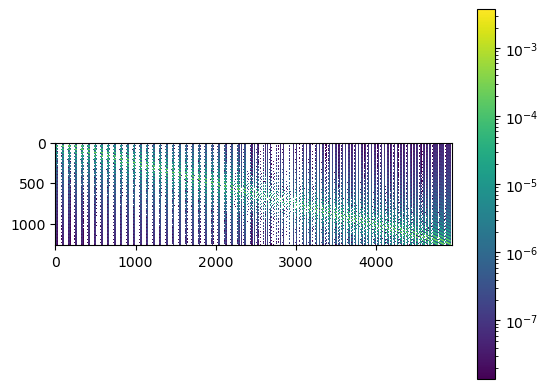

-0.002933444611682085
0.00372421804113609
Layer correction median: 4 m, RMSE:11 m

updated misfit RMSE: 0.14
updated L2-norm: 0.37,  tolerance: 0.2
updated delta L2-norm : 2.01,  tolerance: 0.8

##############################################################################################
iteration 2


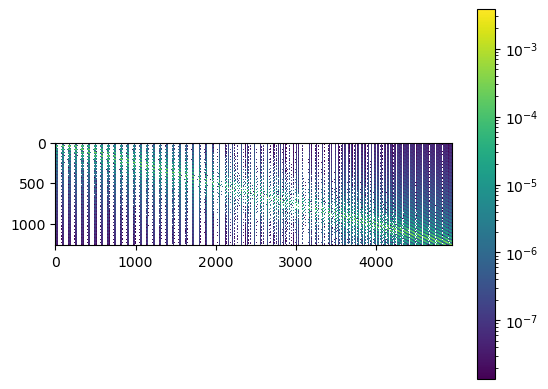

-0.002933444611682085
0.003799122095972717
Layer correction median: 2 m, RMSE:2 m

updated misfit RMSE: 0.04
updated L2-norm: 0.19,  tolerance: 0.2
updated delta L2-norm : 1.96,  tolerance: 0.8

Inversion terminated after 2 iterations with L2-norm = 0.19 because L2-norm < 0.2


In [28]:
# %%snakeviz
prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
    **inversion_kwargs,
    # deriv_type = "annulus",
    deriv_type="prisms",
    # solver_type = "verde least squares",
    solver_type="scipy least squares",
    solver_damping=0.01,
)

In [25]:
g = prism_results.set_index(["northing", "easting"]).to_xarray()
g

<xarray.Dataset>
Dimensions:            (northing: 61, easting: 81)
Coordinates:
  * northing           (northing) float64 0.0 1e+03 2e+03 ... 5.9e+04 6e+04
  * easting            (easting) float64 0.0 1e+03 2e+03 ... 7.9e+04 8e+04
Data variables: (12/14)
    density            (northing, easting) float64 1.383e+03 ... 1.383e+03
    thickness          (northing, easting) float64 116.0 113.0 ... -26.56 -28.74
    top                (northing, easting) float64 -587.2 -590.2 ... -703.3
    bottom             (northing, easting) float64 -703.3 -703.3 ... -732.0
    iter_1_correction  (northing, easting) float64 18.78 19.56 ... 44.58 40.45
    iter_1_top         (northing, easting) float64 -568.4 -570.7 ... -691.5
    ...                 ...
    iter_1_layer       (northing, easting) float64 -568.4 -570.7 ... -691.5
    iter_2_correction  (northing, easting) float64 7.083 6.538 ... 15.94 15.78
    iter_2_top         (northing, easting) float64 -561.4 -564.1 ... -675.8
    iter_2_bottom      (northing, easting) float64 -703.3 -703.3 ... -703.3
    iter_2_density     (northing, easting) float64 1.383e+03 ... 1.383e+03
    iter_2_layer       (northing, easting) float64 -561.4 -564.1 ... -675.8

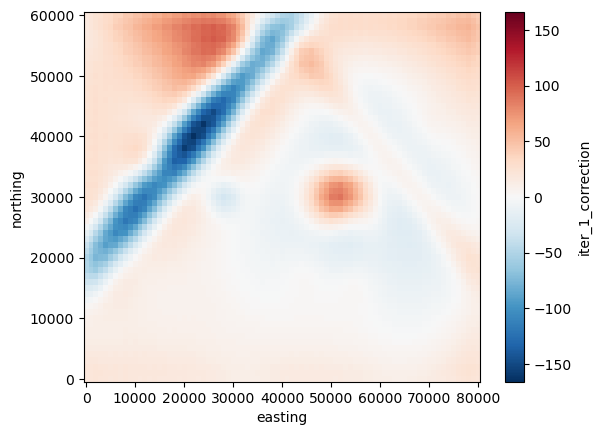

In [26]:
g.iter_1_correction.plot()

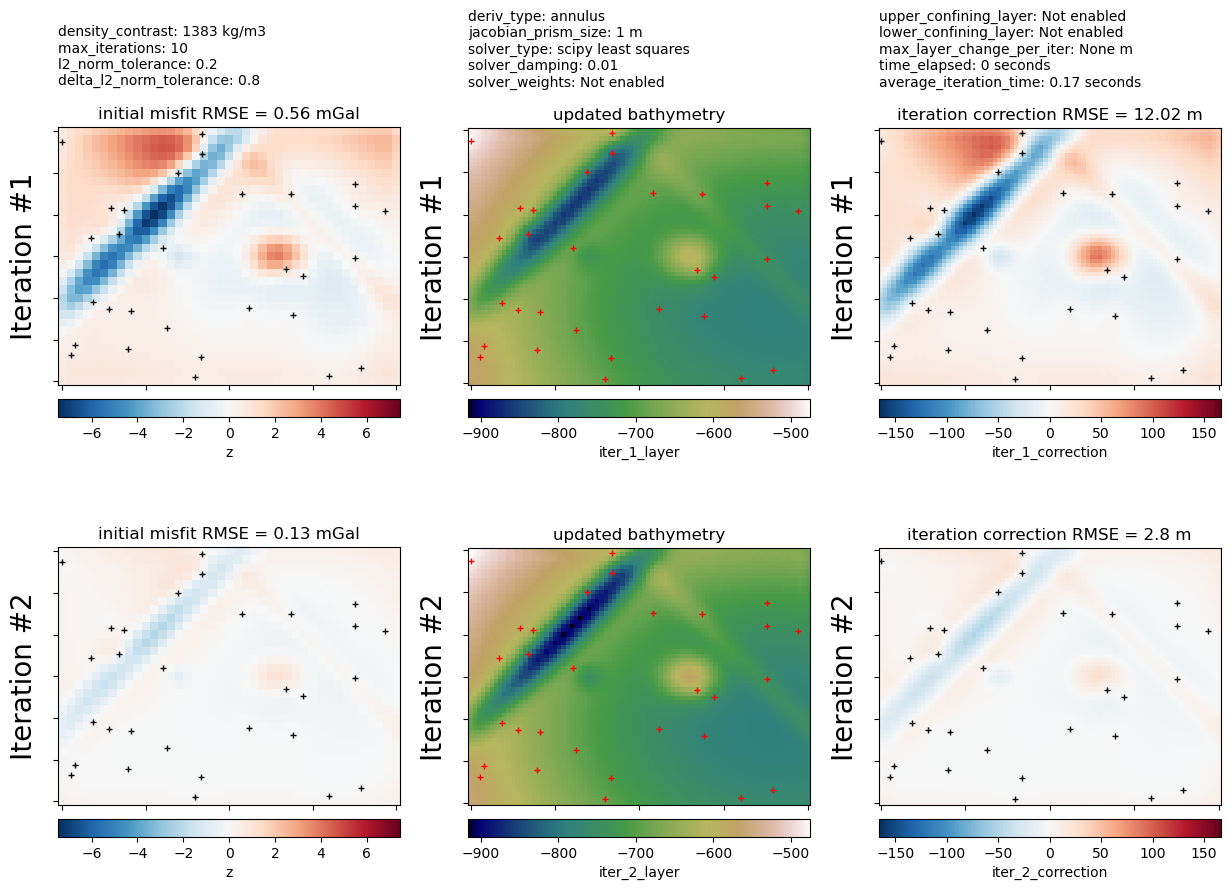

In [24]:
grids = plotting.plot_inversion_results(
    grav_results,
    prism_results,
    params,
    grav_region=inversion_region,
    grav_spacing=sampled_grav_spacing,
    constraints=constraint_points,
    plot_topo_results=False,
    plot_grav_results=False,
    iters_to_plot=4,
)